In [1]:
import pdb
import csv
from math import log10, floor

import numpy as np
import scipy
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

import occur
from occur import Completeness, Hierarchy

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real = objects.query('status == "K" or status == "C" or status == "S"').reset_index(drop=True)
objects_good = objects_real.query('mass != "nan"').reset_index(drop=True)
objects_s    = objects_good.query('status == "S" or status == "SS"').reset_index(drop=True)
planets      = objects_good.query('status == "K" or status == "C" or status == "J"').reset_index(drop=True)
planets_old  = planets.query('status == "K"').reset_index(drop=True)
planets_new  = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [6]:
binary_names = list(objects_s.hostname)
trend_names = list(trends.hostname)

planet_binaries = planets.query('hostname in @binary_names or hostname in @trend_names')
planet_kep = planets.query('hostname in @binary_names')

## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [7]:
merge_columns = list(objects_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

objects_good['name'] = objects_good['hostname']
m_good_spec = pd.merge(objects_good, specmatch, on=['name'])

## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (halo star).

In [8]:
good_spec_filter = m_good_spec.query('mass >= 0.1 and (status == "K" or status == "C")')
print(len(m_good_spec), len(good_spec_filter))

228 134


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

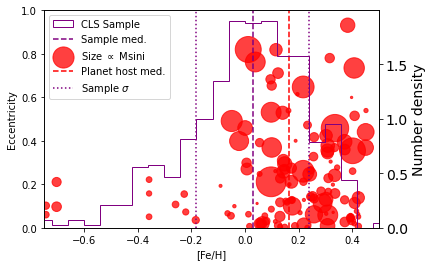

In [9]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='red', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)
ln2 = ax.axvline(x=median_fe, c='red', ls='--', label='Planet host med.')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])
ax.set_ylim([0, 1])

ax2 = ax.twinx()
ln3 = ax2.hist(fe_select, bins=40, histtype='step', color='purple', density=True, label='CLS Sample')
median_sample_fe = np.median(fe_select)
mad_sample_fe = astrostats.mad_std(fe_select)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample med.')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':', label=r'Sample $\sigma$')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2 + lines, labels2 + labels, loc=2, fontsize=10)

#fig.savefig('plots/fe_eccentricity_hist.png', dpi=1000, bbox='tight')
fig.savefig('plots/fe_eccentricity_hist.pdf', bbox='tight')

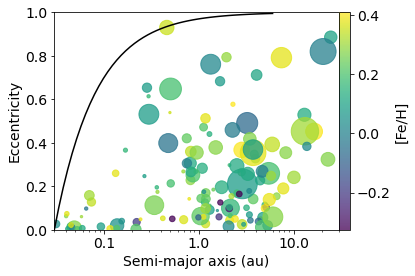

In [10]:
# Overplot peri-distance limit 0.03 AU.
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes
ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

im = ax.scatter(good_spec_filter.axis_med, good_spec_filter.e_med, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe_c, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, color='black', label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('Eccentricity')
plt.colorbar(mappable=im, pad=0, label='[Fe/H]')

ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])

fig.savefig('plots/axis_eccentricity_metallicity.pdf', bbox_inches='tight')

## Compute median metallicity above and below 0.6 eccentricity.

In [11]:
np.median(good_spec_filter.query('e_med >= 0.6').fe_c)

0.104494328664

In [12]:
np.median(good_spec_filter.query('e_med < 0.6').fe_c)

0.197096382919

## Plot eccentricity with confidence intervals.

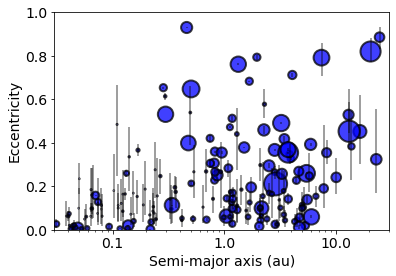

In [13]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets.axis_med, planets.e_med, 
           s=list(30*planets.mass), 
           c='blue', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Size $\propto$ Msini')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets.axis_med, planets.e_minus,
          planets.e_plus, alpha=0.5, color='black')

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])

fig.savefig('plots/axis_eccentricity_ci.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/axis_eccentricity_ci.pdf', bbox_inches='tight')

## Separate singles and multis.

In [9]:
#giants = planets.query('mass >= 20/317.8')
giants = planets.query('mass >= 0.1')
names = np.unique(giants.hostname)
singles = []
multis  = []
for name in names:
    if len(giants.query('hostname == @name')) == 1:
        singles.append(name)
    else:
        multis.append(name)
        
planets_single = giants.query('hostname in @singles')
planets_multi = giants.query('hostname in @multis')

In [10]:
planets_multi = planets_multi.sort_values('axis')
multinames = np.unique(planets_multi.hostname)

In [29]:
planets_single.query('e > 0.5')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
15,23,120066,K,1.0,3.100572,3.155188,2.979116,3.337538,15.721033,24.615172,...,0.911616,0.010171,4.137267e-03,1.338228e-03,9.433381e-03,2.036681,2.550240,1.338228e-03,9.433381e-03,/data/user/lrosenth/legacy/final_run/120066/12...
19,31,126614,K,2.0,0.362820,0.355723,0.325338,0.387393,2.290922,2.291438,...,0.608016,0.274735,2.745359e-01,2.532728e-01,2.977122e-01,0.893369,0.893531,2.532728e-01,2.977122e-01,/data/user/lrosenth/legacy/final_run/126614/12...
63,101,181234,K,1.0,8.341961,9.126340,8.291729,10.745450,7.438414,7.433372,...,0.834500,0.015166,1.518623e-02,1.401858e-02,1.644136e-02,1.843060,1.842456,1.401858e-02,1.644136e-02,/data/user/lrosenth/legacy/final_run/181234/18...
64,106,186427,K,1.0,1.753052,1.752382,1.698974,1.806286,1.676150,1.675950,...,0.684655,0.457006,4.570498e-01,4.191163e-01,4.979615e-01,0.786646,0.786627,4.191163e-01,4.979615e-01,/data/user/lrosenth/legacy/final_run/186427/18...
76,136,213472,C,1.0,3.479000,3.479000,2.885000,4.553000,12.990000,12.990000,...,0.649000,0.005693,6.770000e-22,1.480000e-22,2.460000e-12,2.354657,126802.763000,1.480000e-22,2.460000e-12,/data/user/lrosenth/legacy/final_run/213472/21...
88,159,222582,K,1.0,7.898404,7.878265,7.640243,8.115262,1.335337,1.335260,...,0.763094,0.719440,7.191822e-01,6.598606e-01,7.833150e-01,0.702281,0.702344,6.598606e-01,7.833150e-01,/data/user/lrosenth/legacy/final_run/222582/22...
91,167,26161,C,1.0,13.510000,13.520000,9.840000,21.990000,20.400000,20.450000,...,0.881000,0.015781,7.918622e-03,2.553594e-03,1.668076e-02,1.824835,2.168189,2.553594e-03,1.668076e-02,/data/user/lrosenth/legacy/final_run/26161/261...
94,175,31253,K,1.0,0.479199,0.445900,0.382847,0.509300,1.297626,1.295475,...,0.498848,2.332638,2.340839e+00,2.158756e+00,2.536056e+00,0.523357,0.522898,2.158756e+00,2.536056e+00,/data/user/lrosenth/legacy/final_run/31253/312...
98,186,3651,K,1.0,0.220796,0.220163,0.212587,0.227943,0.295463,0.295465,...,0.620774,5.739451,5.740305e+00,5.323166e+00,6.185504e+00,0.417871,0.417855,5.323166e+00,6.185504e+00,/data/user/lrosenth/legacy/final_run/3651/3651...
109,206,45350,K,1.0,1.774647,1.821184,1.750599,1.895742,1.958377,1.958396,...,0.799434,0.366097,3.660423e-01,3.358119e-01,3.988647e-01,0.831497,0.831528,3.358119e-01,3.988647e-01,/data/user/lrosenth/legacy/final_run/45350/453...


In [13]:
print('Single: ', len(np.unique(planets_single.hostname)))
print('Multi: ', len(np.unique(planets_multi.hostname)))
print('Single eccentric: ', len(planets_single.query('e > 0.5')))
print('Multi eccentric: ', len(planets_multi.query('e > 0.5')))

Single:  65
Multi:  31
Single eccentric:  12
Multi eccentric:  5


## Simbad/WDS estimate of binarity

In [20]:
print('Single: ', 17/len(np.unique(planets_single.hostname)), '+/-', np.sqrt(17)/len(np.unique(planets_single.hostname)))
print('Multi: ', 8/len(np.unique(planets_multi.hostname)), '+/-', np.sqrt(8)/len(np.unique(planets_multi.hostname)))
print('Single eccentric: ', 5/len(np.unique(planets_single.query('e > 0.5').hostname)))


Single:  0.26153846153846155 +/- 0.0634323942402717
Multi:  0.25806451612903225 +/- 0.09123958466923195
Single eccentric:  0.4166666666666667


In [49]:
planets_single.query('e <= 0.5')

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
0,1,104067,K,1.0,0.205392,0.202510,0.185882,0.219072,0.267306,0.267344,...,0.285008,4.559797,4.560409,4.262771,4.877729,0.442612,0.442597,4.262771,4.877729,/data/user/lrosenth/legacy/final_run/104067/10...
1,4,10697,K,1.0,6.394219,6.392002,6.258561,6.525625,2.156211,2.155973,...,0.103728,0.680245,0.680075,0.623103,0.741218,0.712186,0.712230,0.623103,0.741218,/data/user/lrosenth/legacy/final_run/10697/106...
2,5,107148,K,1.0,0.205914,0.202538,0.187767,0.216985,0.366802,0.366796,...,0.208622,9.985084,9.987654,9.216328,10.800504,0.363849,0.363826,9.216328,10.800504,/data/user/lrosenth/legacy/final_run/107148/10...
6,12,114729,K,1.0,0.906738,0.892258,0.839475,0.945356,2.094847,2.094199,...,0.121341,0.611358,0.612168,0.561338,0.666643,0.731452,0.731210,0.561338,0.666643,/data/user/lrosenth/legacy/final_run/114729/11...
11,19,117176,K,1.0,7.235535,7.234080,7.101085,7.366951,0.476587,0.476547,...,0.399435,13.176454,13.176363,12.031456,14.426807,0.339477,0.339477,12.031456,14.426807,/data/user/lrosenth/legacy/final_run/117176/11...
12,20,117207,K,1.0,1.872094,1.869543,1.795250,1.946500,3.743901,3.744161,...,0.154149,0.082141,0.082129,0.075007,0.089695,1.208147,1.208189,0.075007,0.089695,/data/user/lrosenth/legacy/final_run/117207/11...
13,21,11964a,K,1.0,0.635083,0.630694,0.603547,0.658001,3.185356,3.185235,...,0.122298,0.302698,0.302502,0.275326,0.332116,0.871982,0.872122,0.275326,0.332116,/data/user/lrosenth/legacy/final_run/11964a/11...
16,24,120136,K,1.0,4.298490,4.300469,4.225411,4.375587,0.048687,0.048691,...,0.010295,1367.422404,1366.903399,1277.162926,1461.387665,0.106361,0.106371,1277.162926,1461.387665,/data/user/lrosenth/legacy/final_run/120136/12...
22,34,130322,K,1.0,1.149467,1.149237,1.112694,1.185887,0.092901,0.092912,...,0.021410,67.303225,67.254099,62.869563,71.893274,0.225814,0.225855,62.869563,71.893274,/data/user/lrosenth/legacy/final_run/130322/13...
26,40,136925,C,1.0,0.872652,0.840422,0.766177,0.918395,5.209309,5.130608,...,0.146360,0.052280,0.053853,0.049808,0.058131,1.352622,1.342632,0.049808,0.058131,/data/user/lrosenth/legacy/final_run/136925/13...


In [47]:
print(np.unique(planets_multi.hostname), 
  len(np.unique(planets_multi.hostname)))

['108874' '114783' '12661' '128311' '134987' '141399' '145675' '156279'
 '168443' '169830' '177830' '183263' '187123' '217107' '24040' '37124'
 '38529' '4203' '50499' '66428' '68988' '74156' '75732' '82943' '92788'
 '95128' '9826' 'gl317' 'gl876' 'hip109388' 'hip57050'] 31


In [28]:
print(np.mean(planets_single.mass), '+/-', np.std(planets_single.mass)/np.sqrt(len(planets_single) - 1))
print(np.mean(planets_multi.mass), '+/-', np.std(planets_multi.mass)/np.sqrt(len(planets_multi) - 1))
print('')
print(np.median(planets_single.mass), '+/-', np.std(planets_single.mass)/np.sqrt(len(planets_single) - 1))
print(np.median(planets_multi.mass), '+/-', np.std(planets_multi.mass)/np.sqrt(len(planets_multi) - 1))
print('')
print(np.mean(np.log10(planets_single.mass)), '+/-', np.std(np.log10(planets_single.mass))/np.sqrt(len(planets_single) - 1))
print(np.mean(np.log10(planets_multi.mass)), '+/-', np.std(np.log10(planets_multi.mass))/np.sqrt(len(planets_multi) - 1))

2.073963104973847 +/- 0.33092146610259393
2.87902433447971 +/- 0.41537793976120774

0.9232154589 +/- 0.33092146610259393
1.714339992 +/- 0.41537793976120774

0.013443353480734301 +/- 0.06529189546926914
0.22252574186047513 +/- 0.05687194103623001


In [11]:
lowers = 0
for name in multinames:
    masses = list(planets_multi.query('hostname == @name').sort_values('axis').mass)
    if masses[0] > masses[1]:
        lowers += 1

In [12]:
print(lowers/len(multinames))

0.3870967741935484


In [14]:
#For 30 Earth masses.
print(len(np.unique(planets_single.hostname)))
print(len(np.unique(planets_multi.hostname)))

65
31


In [15]:
#For 20 Earth masses.
print(len(np.unique(planets_single.hostname)))
print(len(np.unique(planets_multi.hostname)))

65
31


In [11]:
trendnames = trends.hostname
trendy_singles = planets_single.query('hostname in @trendnames')
trendy_single_circles = trendy_singles.query('e < 0.25')

In [16]:
trendy_singles

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
37,60,145934,K,1.0,2.069045,2.039347,1.809421,2.279885,4.723628,4.729761,...,0.082606,1.045723,1.043213,0.928609,1.179259,0.639595,0.639980,0.928609,1.179259,/data/user/lrosenth/legacy/final_run/145934/14...
44,72,156668,C,1.0,0.101324,0.099085,0.091433,0.106949,1.570776,1.570311,...,0.127107,0.126132,0.126187,0.118565,0.134224,1.085308,1.085191,0.118565,0.134224,/data/user/lrosenth/legacy/final_run/156668/15...
73,123,195019,K,1.0,3.659636,3.655242,3.564412,3.744674,0.137595,0.137601,...,0.021344,125.096620,125.022174,114.479318,136.378507,0.193396,0.193425,114.479318,136.378507,/data/user/lrosenth/legacy/final_run/195019/19...
97,181,34445,K,1.0,0.676592,0.657911,0.618128,0.698477,2.105255,2.105131,...,0.131728,0.511203,0.511520,0.470506,0.555787,0.764911,0.764793,0.470506,0.555787,/data/user/lrosenth/legacy/final_run/34445/344...


In [17]:
trendy_single_circles

,Unnamed: 0,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,e_68,insol,insol_med,insols_minus,insols_plus,teq,teq_med,teq_minus,teq_plus,post_path
37,60,145934,K,1.0,2.069045,2.039347,1.809421,2.279885,4.723628,4.729761,...,0.082606,1.045723,1.043213,0.928609,1.179259,0.639595,0.639980,0.928609,1.179259,/data/user/lrosenth/legacy/final_run/145934/14...
44,72,156668,C,1.0,0.101324,0.099085,0.091433,0.106949,1.570776,1.570311,...,0.127107,0.126132,0.126187,0.118565,0.134224,1.085308,1.085191,0.118565,0.134224,/data/user/lrosenth/legacy/final_run/156668/15...
73,123,195019,K,1.0,3.659636,3.655242,3.564412,3.744674,0.137595,0.137601,...,0.021344,125.096620,125.022174,114.479318,136.378507,0.193396,0.193425,114.479318,136.378507,/data/user/lrosenth/legacy/final_run/195019/19...
97,181,34445,K,1.0,0.676592,0.657911,0.618128,0.698477,2.105255,2.105131,...,0.131728,0.511203,0.511520,0.470506,0.555787,0.764911,0.764793,0.470506,0.555787,/data/user/lrosenth/legacy/final_run/34445/344...


In [18]:
len((planets_multi.hostname))

69

In [19]:
len(np.unique(planets_multi.hostname))

31

In [20]:
print(len(planets_single), len(planets_multi))

65 69


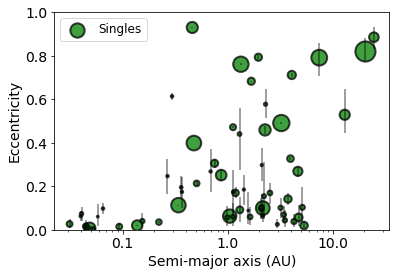

In [21]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets_single.axis_med, planets_single.e_med, 
           s=list(30*planets_single.mass), 
           c='green', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Singles')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_single.axis_med, planets_single.e_minus,
          planets_single.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
#ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.legend(fontsize=12)
#ax.set_xscale('log')
fig.savefig('plots/axis_eccentricity_singles.pdf', bbox='tight')

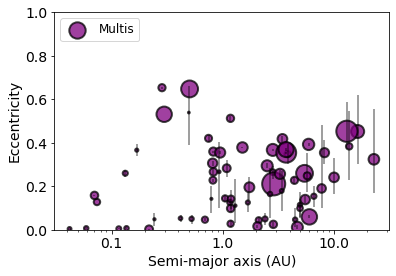

In [22]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets_multi.axis_med, planets_multi.e_med, 
           s=list(30*planets_multi.mass), 
           c='purple', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Multis')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_multi.axis_med, planets_multi.e_minus,
          planets_multi.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
#ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.legend(loc=2, fontsize=12)
#ax.set_xscale('log')
fig.savefig('plots/axis_eccentricity_multis.pdf', dpi=1000, bbox='tight')

In [12]:
merge_columns = list(planets.columns)
merge_columns.append('fe_c')
m_good_spec = pd.DataFrame(columns=merge_columns)

planets['name'] = planets['hostname']
single_spec = pd.merge(planets.query('hostname in @singlenames'), sghosts, on=['name'])
multi_spec  = pd.merge(planets.query('hostname in @multinames'), mghosts, on=['name'])
none_spec   = pd.merge(planets.query('hostname not in @giantnames'), nghosts, on=['name'])

UndefinedVariableError: local variable 'singlenames' is not defined

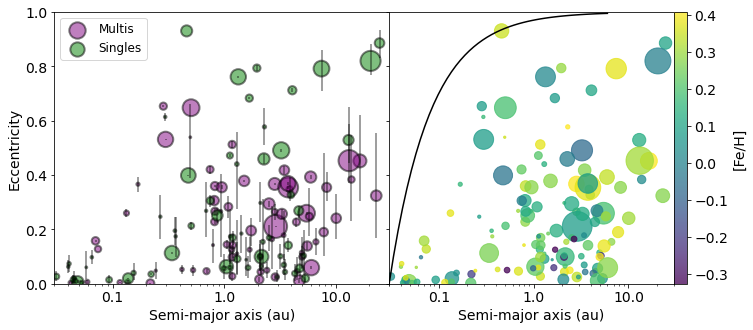

In [23]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].set_xscale('log')
axs[0].set_xticks((0.1, 1, 10))
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

axs[0].scatter(planets_multi.axis_med, planets_multi.e_med, 
           s=list(30*planets_multi.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

# Differentiate between circular-consistent and eccentric-consistent.
axs[0].vlines(planets_multi.axis_med, planets_multi.e_minus,
          planets_multi.e_plus, alpha=0.5, color='black', label='__nolegend__')

axs[0].scatter(planets_single.axis_med, planets_single.e_med, 
           s=list(30*planets_single.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

# Differentiate between circular-consistent and eccentric-consistent.
axs[0].vlines(planets_single.axis_med, planets_single.e_minus,
          planets_single.e_plus, alpha=0.5, color='black', label='__nolegend__')

axs[0].legend(fontsize=12)

axs[0].set_xlabel('Semi-major axis (au)')
axs[0].set_ylabel('Eccentricity')
axs[0].set_xlim([0.03, 30])
axs[0].set_ylim([0, 1])

# Metallicity
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes
axs[1].set_xscale('log')
axs[1].set_xticks((0.1, 1, 10))
axs[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

im = axs[1].scatter(good_spec_filter.axis_med, good_spec_filter.e_med, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe_c, alpha=0.75, label=r'Size $\propto$ Msini')
axs[1].plot(axes, e_max, color='black', label=r'$e_{max}$ (0.03 AU)')
axs[1].set_xlabel('Semi-major axis (au)')
plt.colorbar(mappable=im, pad=0, label='[Fe/H]')

axs[1].set_xlim([0.03, 30])
axs[1].set_ylim([0, 1])

fig.savefig('plots/axis_eccentricity_double.pdf', bbox_inches='tight')

Text(0, 0.5, '$e$')

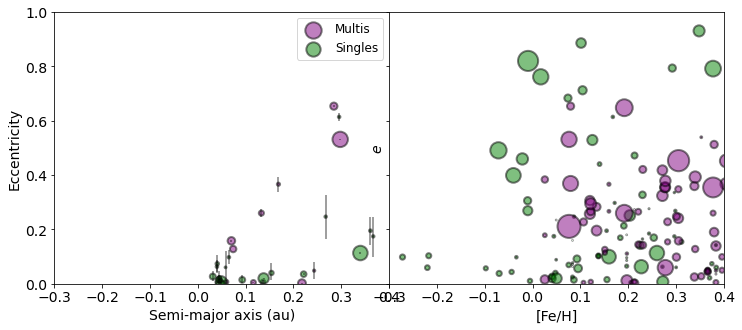

In [51]:
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

axs[0].set_xscale('log')
axs[0].set_xticks((0.1, 1, 10))
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

axs[0].scatter(planets_multi.axis_med, planets_multi.e_med, 
           s=list(30*planets_multi.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

# Differentiate between circular-consistent and eccentric-consistent.
axs[0].vlines(planets_multi.axis_med, planets_multi.e_minus,
          planets_multi.e_plus, alpha=0.5, color='black', label='__nolegend__')

axs[0].scatter(planets_single.axis_med, planets_single.e_med, 
           s=list(30*planets_single.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

# Differentiate between circular-consistent and eccentric-consistent.
axs[0].vlines(planets_single.axis_med, planets_single.e_minus,
          planets_single.e_plus, alpha=0.5, color='black', label='__nolegend__')

axs[0].legend(fontsize=12)

axs[0].set_xlabel('Semi-major axis (au)')
axs[0].set_ylabel('Eccentricity')
axs[0].set_xlim([0.03, 30])
axs[0].set_ylim([0, 1])

axs[1].scatter(single_spec.fe_c, single_spec.e_med, 
           s=list(30*single_spec.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

axs[1].scatter(multi_spec.fe_c, multi_spec.e_med, 
           s=list(30*multi_spec.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

axs[1].set_xscale('linear')
axs[1].set_xlim([-0.3, 0.4])
axs[1].set_ylim([0, 1])
#axs[1].legend(fontsize=12)

axs[1].set_xlabel('[Fe/H]')
axs[1].set_ylabel(r'$e$')

# Explore the population's eccentricity distribution.

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [18]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [19]:
e_pdf = np.histogram(planets.e, range=[0.001,1], density=True)
e_num = np.histogram(planets.e, range=[0.001,1], density=False)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[3.18500319 2.67312767 1.53562654 1.19437619 0.45500046 0.34125034
 0.22750023 0.22750023 0.11375011 0.05687506]
[1.03725425 3.85110208]


## Explore Beta distribution posterior. NOT redrawing e's from posterior.

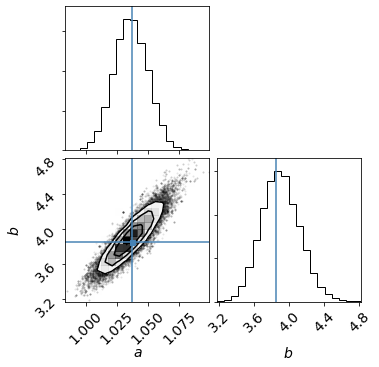

In [27]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("plots/beta.pdf")

In [ ]:
ax = sns.distplot(planets.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
betas_fit = beta(es, fit[0], fit[1])
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [17]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [21]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 4.483768
         Iterations: 2
         Function evaluations: 60
-0.2646530182096953


## Perform hierarchical inference. Use Legacy catalog eccentricity posteriors.

In [20]:
planets_noncirc = planets.query('axis > 0.3')
planets_big_noncirc = planets_noncirc.query('mass > 0.1')

In [30]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 500)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = planets.query('axis > 0.3')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

## Define the population likelihood for the beta distribution. Can generalize later.

In [21]:
def popprob(theta, samples):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, theta[0], theta[1])
        sums.append(np.sum(probs)/N)
    return np.prod(sums) # *exp(−integral(Γ(e|θ)de)) (BUT THAT'S 1!)

def lnpoplike(theta, samples):
    #K = len(samples)
    N = len(samples[0])
    sums = []
    for sample in samples:
        probs = beta(sample, theta[0], theta[1])
        sums.append(np.sum(probs)/N)
    return np.sum(np.log(np.array(sums))) # Clean up N & K stuff

def lnpopprior(theta):
    #a, b = theta
    if 0 < theta[0] < 10 and 0 < theta[1] < 50:
        return 0.0
    else:
        return -np.inf

def lnpopprob(theta, samples):
    return lnpopprior(theta) + np.log(popprob(theta, samples))  #lnpoplike(theta, samples) 

In [31]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
#yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

Optimization terminated successfully.
         Current function value: 393.525179
         Iterations: 22
         Function evaluations: 914
[1.09860989 4.15840171]


## Identify single- & multi-giant systems.

In [22]:
names = np.unique(planets_noncirc.hostname)
nplanets = np.array(planets_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

planets_noncirc = pd.merge(planets_noncirc, db_nplanets, on='hostname').reset_index()

## Separate planets by mass, boundary at Msini = 0.1 Mjup (see mass histograms below). Leave in the planets within 0.1 AU for now.

In [23]:
planets_big_all   = planets.query('mass > 0.1')
planets_small_all = planets.query('mass <= 0.1')
planets_big       = planets.query('mass > 0.1 and axis > 0.3')
planets_small     = planets.query('mass <= 0.1 and axis > 0.3')

### Add number of planets again, WITHIN each sample. Number of planets with Msini less than 0.1 MJup, and number of planets with Msini greater than 0.1 MJup.

In [24]:
names_big = np.unique(planets_big_all.hostname)
nplanets_big = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big = pd.DataFrame({'hostname':names_big, 'nplanets':nplanets_big})

names_small = np.unique(planets_small.hostname)
nplanets_small = np.array(planets_small.groupby('hostname').count()['status'])
db_nplanets_small = pd.DataFrame({'hostname':names_small, 'nplanets':nplanets_small})

planets_big   = pd.merge(planets_big, db_nplanets_big, on='hostname').reset_index()
planets_small = pd.merge(planets_small, db_nplanets_small, on='hostname').reset_index()

planets_big_all   = pd.merge(planets_big_all, db_nplanets_big, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small, on='hostname').reset_index()

### Split giant planets into single-giant, multi-giant.

In [25]:
planets_big_single = planets_big.query('nplanets == 1 and mass > 0.1').reset_index()
planets_big_multi  = planets_big.query('nplanets != 1 and mass > 0.1').reset_index()

## Perform hierarchical inference with real posteriors.

### First, make re-sampled histogram of eccentricity posterior values. Do for all planets.

In [35]:
db_all = pd.read_csv('../legacy_samples/samples_all_joker.csv').sample(500)
#chains_26161 = pd.read_csv('../CLSI/Joker_results/26161_chains_combined.csv').sample(len(db_all))
#chains_213472 = pd.read_csv('../CLSI/Joker_results/213472_chains.csv').sample(len(db_all))
posts_all = []

for column in db_all.columns:
    if '_e' in column:
        posts_all.append(np.array(db_all[column]))
        nans = np.argwhere(np.isnan(db_all[column]))
        if len(nans) != 0:
            print(column)
        hist, bin_edges = np.histogram(db_all[column], bins=20, 
                                       range=(np.percentile(db_all[column], 2), 
                                              np.percentile(db_all[column], 98)))
        mode = bin_edges[np.argmax(hist)]
        if mode > 0.7:
            print(column, mode)
    
posts_all = np.array(posts_all)
#db_all = None
#chains_26161 = None
#chains_213472 = None

120066_e1 0.9417333119915786
181234_e1 0.8583672110222185
222582_e1 0.7622710839782588
26161_e1 0.7984902401713992
45350_e1 0.7897080383009619
80606_e1 0.9305511188089125
87883_e1 0.7122308273197026


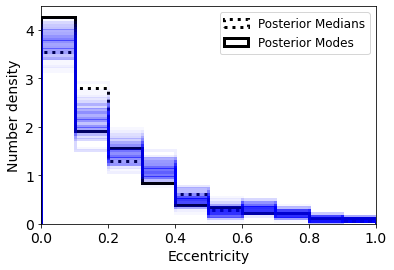

In [37]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

# Compute medians and approximate modes.
medians = np.median(posts_all, axis=1)
modes = []
for post in posts_all:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)

fig.savefig('plots/eccentricity_histogram_full.pdf', bbox_inches='tight')

In [38]:
db_big_noncirc = pd.read_csv('../legacy_samples/samples_big_noncirc_joker.csv').sample(500)
posts_big_noncirc = []

for column in db_big_noncirc.columns:
    if '_e' in column:
        posts_big_noncirc.append(np.array(db_big_noncirc[column]))
    
posts_big_noncirc = np.array(posts_big_noncirc)
db_big_noncirc = None

### Make same histogram as full sample, for large & noncircular planets.

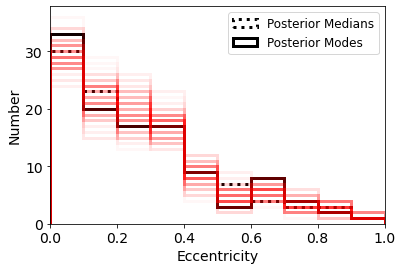

In [39]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

# Compute medians and approximate modes.
medians = np.median(posts_big_noncirc, axis=1)
big_noncirc_modes = []
for post in posts_big_noncirc:
    hist, bin_edges = np.histogram(post, bins=50, range=(np.percentile(post, 5), 
                                                         np.percentile(post, 95)))
    big_noncirc_modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=False, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(big_noncirc_modes, bins=10, density=False, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number')
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0, 1])

for i in np.arange(len(posts_big_noncirc)):
    dist = posts_big_noncirc[:,i]
    ax.hist(dist, bins=10, density=False, histtype='step', 
        range = (0, 1), lw=3, color='red', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)

fig.savefig('plots/eccentricity_histogram_big_noncirc.pdf', dpi=1000, bbox_inches='tight')

In [37]:
lnpopprob(fit_noncirc, posts_big_noncirc)

24.970376190110947

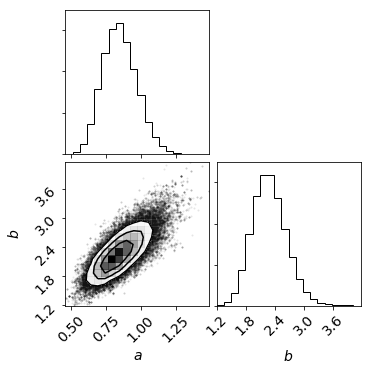

In [45]:
ndim, nwalkers = 2, 100
pos = [fit_noncirc + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_noncirc = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, #lnpoplike
                                           args=(posts_big_noncirc,))
sampler_big_noncirc.run_mcmc(pos, 1000, progress=True)

samples_big_noncirc = sampler_big_noncirc.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. 
a_big_noncirc_median = np.median(samples_big_noncirc[:, 0])
b_big_noncirc_median = np.median(samples_big_noncirc[:, 1])

fig = corner.corner(samples_big_noncirc, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_noncirc.pdf", bbox_inches='tight')

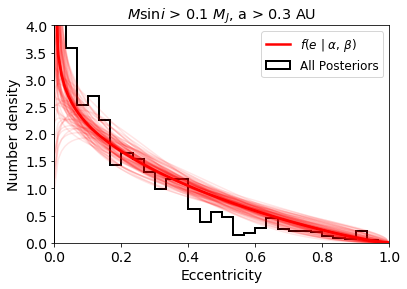

In [46]:
fig, ax = plt.subplots() #masses_big_noncirc.e
#ax.hist(big_noncirc_modes, bins=10, range=(0, 1),
#        density=True, histtype='step', lw=2, 
#        color='black', label='Posterior Modes')
ax.hist(posts_all.flatten(), bins=30, range=(0, 1),
        density=True, histtype='step', lw=2, 
        color='black', label='All Posteriors')

matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
matplotlib.rcParams.update({'font.size': 12})
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_big_noncirc_median, b_big_noncirc_median)

ax.plot(es, beta_median, label=r'$f(e$ | $\alpha$, $\beta$)', color='red', linewidth=2.5)
for a, b in samples_big_noncirc[np.random.randint(len(samples_big_noncirc), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='red', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('plots/eccentricity_pop_big_noncirc_real.pdf', bbox_inches='tight')

## Big singles & multis.

In [31]:
db_big_single = pd.read_csv('../legacy_samples/samples_big_single_noncirc_joker.csv').sample(500).reset_index(drop=True)
posts_big_single = []

for column in db_big_single.columns:
    if '_e' in column:
        hist, bin_edges = np.histogram(db_big_single[column], bins=20, range=(0, 1))
        mode = bin_edges[np.argmax(hist)]
        posts_big_single.append(np.array(db_big_single[column]))
        
        nans = np.argwhere(np.isnan(db_big_single[column]))
        if len(nans) != 0:
            print(column)
    
posts_big_single = np.array(posts_big_single[1:])    
db_big_single = None

100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


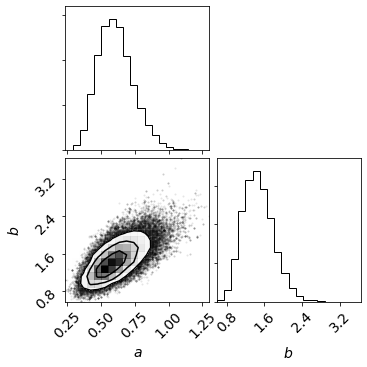

In [43]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_single,))
sampler_big_single.run_mcmc(pos, 1000, progress=True)

samples_big_single = sampler_big_single.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_single_median = np.median(samples_big_single[:, 0])
b_big_single_median = np.median(samples_big_single[:, 1])

fig = corner.corner(samples_big_single, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_single_noncirc.pdf", bbox_inches='tight')

In [44]:
np.percentile(samples_big_single, [16, 50, 84], axis=0)

array([[0.47970976, 1.14852277],
       [0.59947855, 1.44547581],
       [0.74064685, 1.7880213 ]])

NameError: name 'a_big_single_median' is not defined

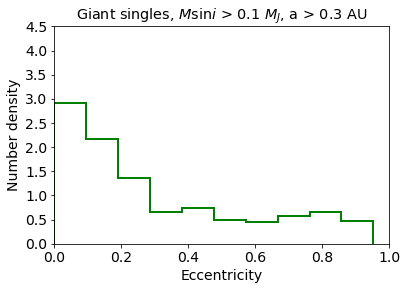

In [42]:
modes_single = []
for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=20, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])

fig, ax = plt.subplots()

#planets_big_single.e
#ax.hist(modes_single, bins=10, range=(0, 1), density=True, 
#        histtype='step', lw=2, color='green', label='Posterior Modes')
ax.hist(posts_big_single.flatten(),
        density=True, histtype='step', lw=2, 
        color='green', label='All Posteriors')
matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4.5])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, 
                                  b_big_single_median)
ax.plot(es, beta_big_single_median, label=r'$\beta(e$ | a, b)', 
                                  color='green', linewidth=2.5)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), 
                                                 size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('plots/eccentricity_pop_big_single_noncirc.pdf', bbox_inches='tight')

In [32]:
db_big_multi = pd.read_csv('../legacy_samples/samples_big_multi_noncirc.csv').sample(1000)
posts_big_multi = []

for column in db_big_multi.columns:
    if '_e' in column:
        hist, bin_edges = np.histogram(db_big_multi[column], bins=20, range=(0, 1))
        mode = bin_edges[np.argmax(hist)]
        if column != '66428_e2': # NOT CHERRY-PICKING, JUST DEBUGGING
            posts_big_multi.append(np.array(db_big_multi[column]))
            if mode > 0.35:
                print(column)
    
posts_big_multi = np.array(posts_big_multi)
#db_big_multi = None

12661_e1
145675_e1
145675_e2
156279_e1
168443_e1
177830_e2
217107_e2
38529_e1
4203_e1
66428_e1
68988_e2
74156_e1
74156_e2
82943_e1
92788_e1
92788_e2
95128_e3
hip57050_e2
183263_e1


100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]


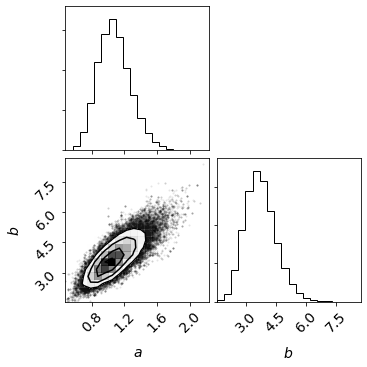

In [46]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_multi,))
sampler_big_multi.run_mcmc(pos, 1000, progress=True)

samples_big_multi = sampler_big_multi.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_multi_median = np.median(samples_big_multi[:, 0])
b_big_multi_median = np.median(samples_big_multi[:, 1])

fig = corner.corner(samples_big_multi, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_multi_noncirc.pdf")

In [47]:
np.percentile(samples_big_multi, [16, 50, 84], axis=0)

array([[0.88216689, 2.98026971],
       [1.06453227, 3.67667205],
       [1.27905913, 4.49018815]])

In [50]:
print(np.mean(sghosts.fe_c), np.std(sghosts.fe_c)/np.sqrt(len(sghosts) - 1))
print(np.mean(mghosts.fe_c), np.std(mghosts.fe_c)/np.sqrt(len(mghosts) - 1))

0.12890935117626734 0.018998930162425817
0.22766434685376935 0.026793720520699085


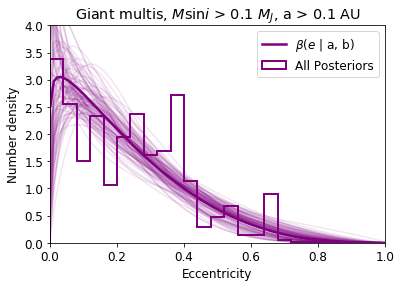

In [97]:
fig, ax = plt.subplots()

modes_multi = []
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=30, range=(np.percentile(post, 2), 
                                                         np.percentile(post, 98)))
    modes_multi.append(bin_edges[np.argmax(hist)])

#planets_big_multi.e
#ax.hist(modes_multi, bins=10, range=(0,1), density=True, 
#        histtype='step', lw=2, color='purple', label='Posterior Modes')
ax.hist(posts_big_multi.flatten(), bins=25, range=(0, 1),
        density=True, histtype='step', lw=2, 
        color='purple', label='All Posteriors')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant multis, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
#'''
# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
#'''
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_multi_noncirc.png', dpi=1000, bbox_inches='tight')

## Nonparametrically test whether two eccentricity distributions are different.

In [37]:
# Compute medians and approximate modes.
tens_single    = np.percentile(posts_big_single, 10)
tens_multi     = np.percentile(posts_big_multi, 10)
medians_single = np.median(posts_big_single)
medians_multi  = np.median(posts_big_multi)
ninety_single  = np.percentile(posts_big_single, 90)
ninety_multi   = np.percentile(posts_big_multi, 90)

modes_single = []
modes_multi  = []

for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])
    
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_multi.append(bin_edges[np.argmax(hist)])    

In [39]:
print(tens_single, tens_multi)
print(medians_single, medians_multi)
print(ninety_single, ninety_multi)

0.033104403489582684 0.027581764767729475
0.19917991310512953 0.23458640062762026
0.7662070520952852 0.4678756302308186


In [10]:
integrals_single = []
integrals_multi  = []

all_single = []
all_multi  = []

for n in range(2000):
    eccys_single = []
    eccys_multi  = []

    for post in posts_big_single:
        eccys_single.append(np.random.choice(post))

    for post in posts_big_multi:
        eccys_multi.append(np.random.choice(post))
        
    integral_single = np.percentile(eccys_single, 84.1)
    integral_multi  = np.percentile(eccys_multi, 84.1)
    
    integrals_single.append(integral_single)
    integrals_multi.append(integral_multi)
    
    all_single.append(eccys_single)
    all_multi.append(eccys_multi)

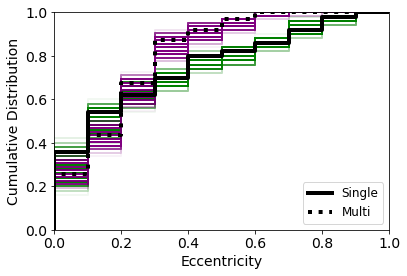

In [158]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for thing in all_single:
    singlehist, single_edges = np.histogram(thing, normed=True, bins=10, range=(0, 1))
    singlechist = np.cumsum(singlehist)/np.sum(singlehist)
    x = np.vstack((single_edges, np.roll(single_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((singlechist, singlechist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

for thing in all_multi:
    multihist, multi_edges = np.histogram(thing, normed=True, bins=10, range=(0, 1))#bins=19
    multichist = np.cumsum(multihist)/np.sum(multihist)
    x = np.vstack((multi_edges, np.roll(multi_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((multichist, multichist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')
    
#modes_single = #[]
#modes_multi  = #[]

singlehist, single_edges = np.histogram(modes_single, normed=True, bins=10, range=(0, 1))
singlechist = np.cumsum(singlehist)/np.sum(singlehist)
x = np.vstack((single_edges, np.roll(single_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((singlechist, singlechist)).T.flatten(), 0, 0), 
        color='black', lw=4, alpha=1, label='Single')

multihist, multi_edges = np.histogram(modes_multi, normed=True, bins=10, range=(0, 1))
multichist = np.cumsum(multihist)/np.sum(multihist)
x = np.vstack((multi_edges, np.roll(multi_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((multichist, multichist)).T.flatten(), 0, 0), 
        color='black', ls=':', lw=4, alpha=1, label='Multi')  
    
#ax.set_xlabel(r'$e$')
ax.set_xlabel(r'Eccentricity')
ax.set_ylabel('Cumulative Distribution')

ax.legend(fontsize=12, loc=4)

fig.savefig('plots/eccentricity_cumulative_single_multi.pdf', bbox_inches='tight')

In [127]:
print(len(all_single), len(all_multi))

2000 2000


In [16]:
kolmogorovs = []
probs = []
for i in range(2000):
    singles = all_single[np.random.randint(0, len(all_single))]
    multis  = all_multi[np.random.randint(0, len(all_multi))]
    kolmogorov = scipy.stats.ks_2samp(singles, multis)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [133]:
darlings = []
dprobs = []
for i in range(2000):
    singles = all_single[i]
    multis  = all_multi[i]
    anderson = scipy.stats.anderson_ksamp([singles, multis])
    darlings.append(anderson[0])
    dprobs.append(anderson[2])

(-2.1, 0)

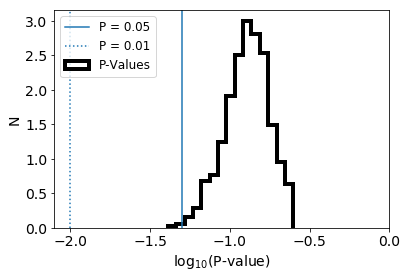

In [136]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.hist(np.log10(dprobs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')

ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(loc=2, fontsize=12)
ax.set_xlim([-2.1, 0])
#fig.savefig('plots/ks_pvalue_lonely_pair.pdf', bbox_inches='tight')

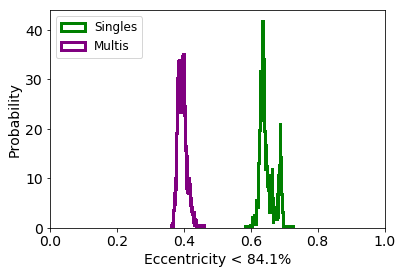

In [135]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_xlabel('Eccentricity < 84.1%')
ax.set_ylabel('Probability')

ax.hist(integrals_single, density=True, histtype='step',  
        bins=100, lw=3, color='green', alpha=1, label='Singles')
ax.hist(integrals_multi, density=True, histtype='step',  
        bins=100, lw=3, color='purple', alpha=1, label='Multis')

ax.legend(fontsize=12)

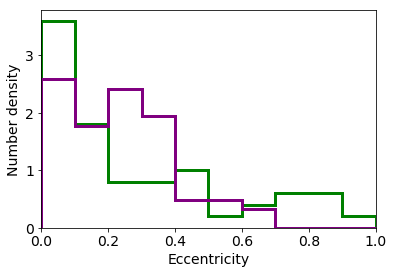

In [100]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_xlim([0, 1])
    
ax.hist(modes_single, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='green', alpha=1, label='Posterior Modes')
ax.hist(modes_multi, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='purple', alpha=1, label='Posterior Modes')
'''
for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)
'''
fig.savefig('analysis_plots/eccentricity_nonparametric_comparison.pdf', bbox_inches='tight')

## Make single/multi comparison plot for beta distributions.

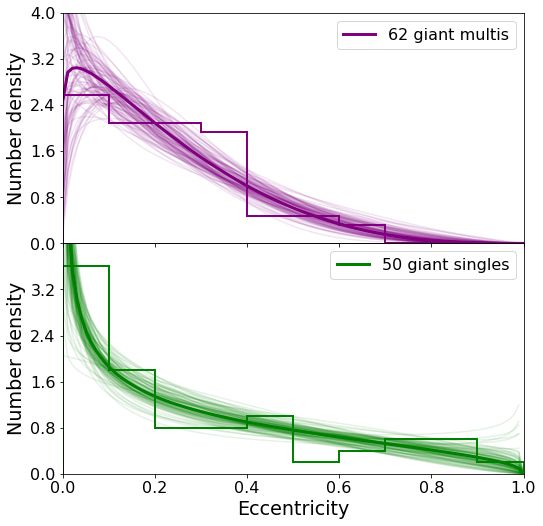

In [101]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(8, 8))

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('Eccentricity', fontsize='large')
ax1.set_ylabel('Number density', fontsize='large')
#ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU', fontsize='x-large')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 4])

# Plot histogram of singles. planets_big_single.e
ax1.hist(modes_single, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='green', label='_nolegend_')

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax1.plot(es, beta_big_single_median, label=r'{} giant singles > 0.3 au'.format(nsingle), 
         color='green', linewidth=3)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax1.plot(es, betas, c='green', alpha=0.1)
ax1.legend(fontsize=16)

# Remove topmost tick mark from bottom panel.
nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Number density', fontsize='large')
#ax2.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU', fontsize='x-large')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 4])
#planets_big_multi.e
ax2.hist(modes_multi, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='purple', label='_nolegend_')
#label=r'$\beta(e$ | a, b)'

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax2.plot(es, beta_big_multi_median, label=r'{} giant multis > 0.3 au'.format(nmulti), 
         color='purple', linewidth=3)
ax2.set_xticklabels('')

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax2.plot(es, betas, c='purple', alpha=0.1)
ax2.legend(fontsize=16)

ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

#fig.savefig('plots/eccentricity_pop_hist_comparison.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/eccentricity_pop_hist_comparison.pdf', bbox_inches='tight')

In [46]:
print(len(samples_big_single), len(samples_big_multi))

90000 90000


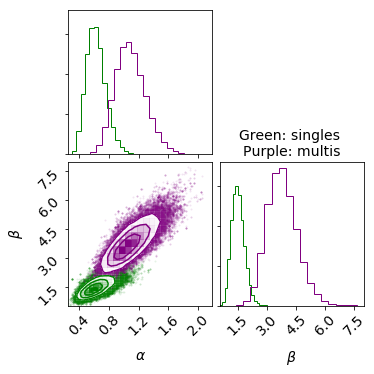

In [45]:
## Plot the two distributions on top of each other.
fig = corner.corner(samples_big_single, labels=[r"$\alpha$", r"$\beta$"], color='green')
corner.corner(samples_big_multi, fig=fig, color='purple')
# Histogram limits.
fig.axes[0].set_xlim([0.25, 2.2])
fig.axes[0].set_ylim([0, 1.8*10**4])
fig.axes[3].set_xlim([0.55, 8])
fig.axes[3].set_ylim([0, 1.8*10**4])
# Scatterplot limits.
fig.axes[2].set_xlim([0.25, 2.2])
fig.axes[2].set_ylim([0.55, 8])
# Plots to clarify.
#fig.axes[0].set_title(r'$M$sin$i$ > 0.1 $M_J$' + ' \na > 0.1 AU')
fig.axes[3].set_title('Green: singles \nPurple: multis', fontsize=14)
fig.savefig("plots/corner_real_big_noncirc_comparison_new.pdf", bbox_inches='tight')

(array([2.9236, 2.0772, 1.2352, 0.7564, 0.7956, 0.266 , 0.534 , 0.6628,
        0.5116, 0.2376]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

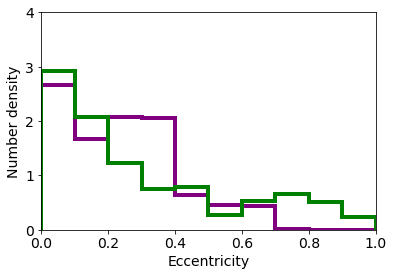

In [103]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')

ax.hist(posts_big_multi.flatten(), bins=10, range=(0, 1),
        density=True, histtype='step', lw=4, 
        color='purple', label='Multi Posteriors')
ax.hist(posts_big_single.flatten(), bins=10, range=(0, 1),
        density=True, histtype='step', lw=4, 
        color='green', label='Multi Posteriors')

## See how many multis would have to scatter to produce the single tail.

In [64]:
len(np.unique(planets.query('mass <= 0.1 and axis < 0.3').hostname))

26

In [61]:
print(len(np.unique(planets_big_single.hostname)), len(np.unique(planets_big_multi.hostname)))

49 30


In [67]:
len(planets.query('mass >= 30/317.8'))
#len(planets.query('mass >= 0.1'))

134

In [74]:
len(np.unique(planets_big_multi.query('axis > 0.3').hostname))

30

In [60]:
print(len(np.unique(planets_big_single.query('e > 0.5').hostname)))

11


### About a fifth of multis would have to scatter to produce this result.

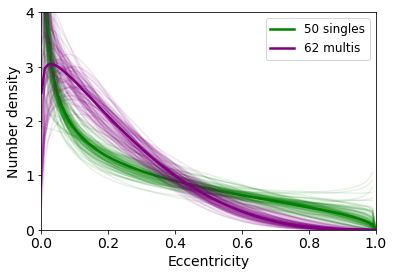

In [107]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend(fontsize=12)
#fig.savefig('plots/eccentricity_real_comparison_beta_big_noncirc.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/eccentricity_real_comparison_beta_big_noncirc.pdf', bbox_inches='tight')

## Look at multi stats for the whole sample, and for giants.

In [13]:
names = np.unique(planets.query('mass >= 0.1 and hostname != "143761"').hostname)
multistats = []
singlenames = []
multinames = []
giantnames = []
singlecircnames = []
singleeccnames  = []
single_tail_names = []
single_nots_names = []
hotnames  = []
coldnames = []

bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215']

for name in names:
    sample = planets.query('mass >= 0.1 and hostname == @name')
    ngiants = len(sample)
    if ngiants >= 1:
        giantnames.append(name)
    multistats.append(ngiants)
    
    if ngiants == 1:
        singlenames.append(name)
        if np.array(sample.e)[0] < 0.2:
            singlecircnames.append(name)
        else:
            singleeccnames.append(name)

        if np.array(sample.e)[0] < 0.5:
            single_nots_names.append(name)
        else:
            single_tail_names.append(name)
            
    elif ngiants > 1:
        multinames.append(name)
    else:
        pass
    
    for axis in list(sample.axis):
        if axis <= 0.1:
            hotnames.append(name)
        else:coldnames.append(name)
            
hotnames = np.unique(hotnames)
coldnames = np.unique(coldnames)

single_tail_names = np.unique(single_tail_names)
single_nots_names = np.unique(single_nots_names)

In [74]:
print(len(singlecircnames), len(singleeccnames))

38 26


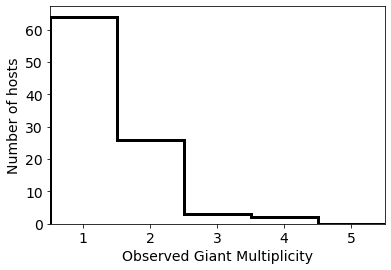

In [75]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(multistats, color='black', histtype='step', lw=3, range=(0.5, 5.5), bins=5)
ax.set_xlim([0.5, 5.5])
ax.set_xlabel('Observed Giant Multiplicity')
ax.set_ylabel('Number of hosts')
fig.savefig('plots/observed_giant_multiplicity.pdf', bbox_inches='tight')

## Make log-axis ratio for two-planet systems.

In [14]:
logratios = []
logperratios = []
for index, name in enumerate(giantnames):
    if multistats[index] >= 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logratios.append(np.log10(np.amax(pair.axis)) - np.log10(np.amin(pair.axis)))
        logperratios.append(np.log10(np.amax(pair.per)) - np.log10(np.amin(pair.per)))
        
perratios = 10**np.abs(logperratios)

In [45]:
len(logratios)

31

In [46]:
np.sort(perratios)

array([2.00960188e+00, 2.01907977e+00, 2.02305393e+00, 2.93070420e+00,
       3.66521217e+00, 4.03253611e+00, 4.40975361e+00, 4.97715236e+00,
       6.46782503e+00, 6.88346737e+00, 8.01264957e+00, 8.12443184e+00,
       8.77281072e+00, 1.02687825e+01, 1.14671082e+01, 1.28993628e+01,
       1.33775199e+01, 1.44226784e+01, 1.65496749e+01, 2.30514741e+01,
       2.55445712e+01, 3.01079060e+01, 3.55324266e+01, 3.56703792e+01,
       4.74282898e+01, 1.49079066e+02, 2.77693466e+02, 3.32392143e+02,
       7.20473567e+02, 1.08917656e+03, 2.64476922e+03])

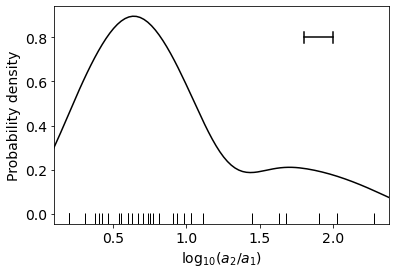

In [43]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
ax.set_xlim([np.amin(logratios) - 0.1, np.amax(logratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($a_2/a_1$)')
ax.set_ylabel(r'Probability density')
sns.kdeplot(logratios, bw=0.2, ax=ax, color='black')
sns.distplot(logratios, rug=True, hist=False, kde=False, ax=ax, color='black')
ax.plot([1.8, 2], [0.8, 0.8], color='black')
ax.plot([2, 2], [0.775, 0.825], color='black')
ax.plot([1.8, 1.8], [0.775, 0.825], color='black')
fig.savefig('plots/observed_axis_ratios.pdf', bbox_inches='tight')

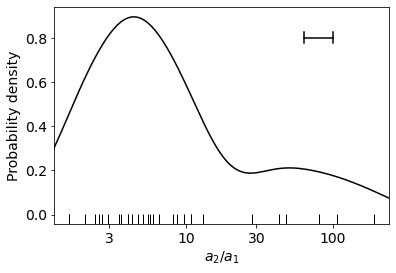

In [27]:
matplotlib.rcParams.update({'font.size': 14})

def format_func(value, tick_number):
    
    # find number of 3's / 10's
    N = value #int(np.round(2 * value / np.pi))
    if N == 1:
        return "10"
    elif np.abs(N - np.log10(30)) <0.01:
        return r"30"
    elif N == 2:
        return r"100"
    #elif N % 2 > 0:
    #    return r"${0}\pi/2$".format(N)
    #else:
    #    return r"${0}\pi$".format(N // 2)
    #return r'{}'.format(10**value)

fig, ax = plt.subplots()
ax.set_xlim([np.amin(logratios) - 0.1, np.amax(logratios) + 0.1])
ax.set_xlabel(r'$a_2/a_1$')
ax.set_ylabel(r'Probability density')

sns.kdeplot(logratios, bw=0.2, ax=ax, color='black')
sns.distplot(logratios, rug=True, hist=False, kde=False, ax=ax, color='black')

ax.plot([1.8, 2], [0.8, 0.8], color='black')
ax.plot([2, 2], [0.775, 0.825], color='black')
ax.plot([1.8, 1.8], [0.775, 0.825], color='black')

#ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

ax.set_xticks([np.log10(3), np.log10(10), np.log10(30), np.log10(100)])
ax.set_xticklabels(['3', '10', '30', '100'])

fig.savefig('plots/observed_axis_ratios.pdf', bbox_inches='tight')

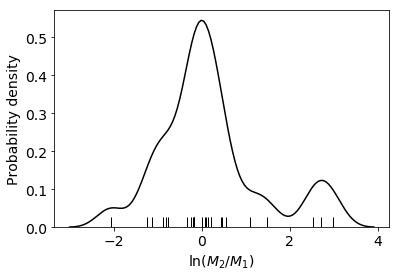

In [44]:
logmassratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logmassratios.append(np.log(np.array(pair.mass)[0]) - \
                             np.log(np.array(pair.mass)[1]))

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
#ax.set_xlim([np.amin(logmassratios) - 0.1, np.amax(logmassratios) + 0.1])
#ax.set_xlabel(r'log$_{10}$($M_2/M_1$)')
ax.set_xlabel(r'ln($M_2/M_1$)')
ax.set_ylabel(r'Probability density')
sns.distplot(logmassratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/observed_mass_ratios.pdf', bbox_inches='tight')

Text(0, 0.5, 'M2 (MJup)')

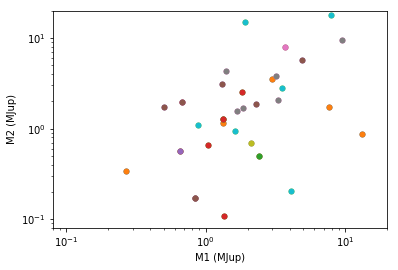

In [28]:
fig, ax = plt.subplots()
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
for hostname in pairs.hostname:
    ax.scatter(np.array(pairs.query('hostname==@hostname').mass)[0], 
               np.array(pairs.query('hostname==@hostname').mass)[1])
    
ax.set_xlim([0.08, 20])
ax.set_ylim([0.08, 20])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('M1 (MJup)')
ax.set_ylabel('M2 (MJup)')

## Compare metallicity distributions of single-giant and multi-giant hosts.

In [15]:
ghosts  = specmatch.query('name in @giantnames and name != "143761"')
sghosts = specmatch.query('name in @singlenames and name != "143761"')
mghosts = specmatch.query('name in @multinames and name != "143761"')
nghosts = specmatch.query('name not in @giantnames and name != "143761"')

scghosts = specmatch.query('name in @singlecircnames and name != "143761"')
seghosts = specmatch.query('name in @singleeccnames and name != "143761"')

stailghosts = specmatch.query('name in @single_tail_names and name != "143761"')
snotsghosts = specmatch.query('name in @single_nots_names and name != "143761"')

hghosts = specmatch.query('name in @hotnames and name != "143761"')
cghosts = specmatch.query('name in @coldnames and name != "143761"')

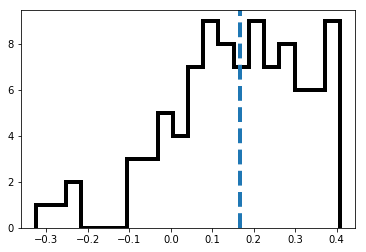

In [22]:
fig, ax = plt.subplots()
ax.hist(ghosts.fe_c, bins=20, histtype='step', lw=4, color='black')
ax.axvline(np.median(ghosts.fe_c),  lw=4, ls='--')

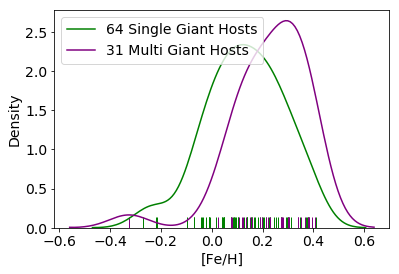

In [43]:
fig, ax = plt.subplots()

sns.distplot(sghosts.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Giant Hosts'.format(len(sghosts)))
sns.distplot(mghosts.fe_c, rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Giant Hosts'.format(len(mghosts)))

ax.set_xlim([-0.5, 0.42])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/single_multi_giant_fe_histogram.pdf')
fig.savefig('plots/single_multi_giant_fe_histogram.png', bbox_inches='tight', dpi=1000)

In [17]:
sghosts.query('fe_c < -0.1')[['name', 'fe_c']]

,name,fe_c
40,114729,-0.272001
93,136925,-0.217220
395,4208,-0.220051


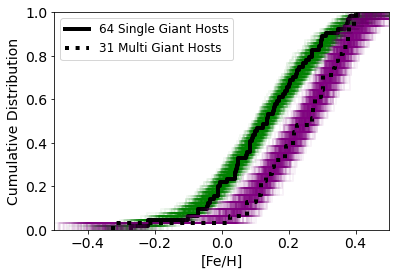

In [79]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(sghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(sghosts.fe_c, normed=True, bins=5*len(sghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(sghosts)))


for i in np.arange(500):
    metals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(mghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(mghosts.fe_c, normed=True, bins=5*len(mghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(mghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_fe_cumulative.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_fe_cumulative.png', bbox_inches='tight', dpi=1000)

In [40]:
darlings = []
dprobs = []
for i in np.arange(10**5):
    solometals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    multimetals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    anderson = scipy.stats.anderson_ksamp([solometals, multimetals])
    darlings.append(anderson[0])
    dprobs.append(anderson[2])

In [45]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    multimetals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [31]:
print(scipy.stats.percentileofscore(probs, 0.05), scipy.stats.percentileofscore(probs, 0.01))

92.236 53.236


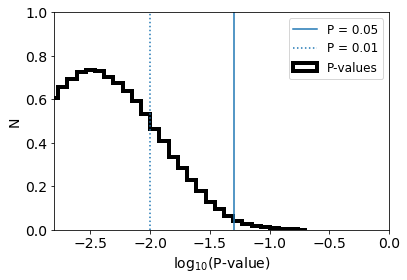

In [46]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(dprobs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-2.8, 0])
ax.set_ylim([0, 1])
ax.legend(fontsize=12)
fig.savefig('plots/ad_pvalue_single_multi_metals.pdf', bbox_inches='tight')

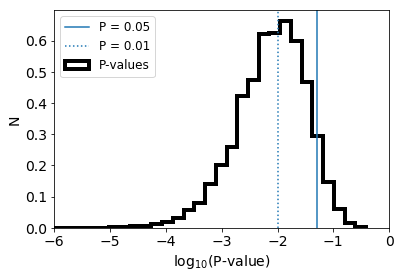

In [51]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_metals.pdf', bbox_inches='tight')

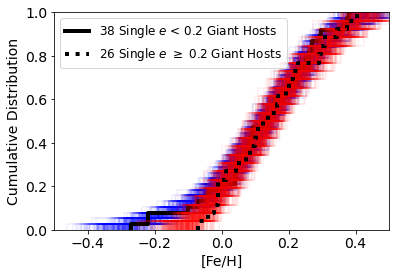

In [80]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(scghosts.fe_c, scghosts.fe_err_c)
    circhist, circ_edges = np.histogram(metals, normed=True, bins=5*len(scghosts))
    circchist = np.cumsum(circhist)/np.sum(circhist)
    x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

circhist, circ_edges = np.histogram(scghosts.fe_c, normed=True, bins=5*len(scghosts))
circchist = np.cumsum(circhist)/np.sum(circhist)
x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single $e$ < 0.2 Giant Hosts'.format(len(scghosts)))


for i in np.arange(500):
    metals = np.random.normal(seghosts.fe_c, seghosts.fe_err_c)
    ecchist, ecc_edges = np.histogram(metals, normed=True, bins=5*len(seghosts))
    eccchist = np.cumsum(ecchist)/np.sum(ecchist)
    x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    
    
ecchist, ecc_edges = np.histogram(seghosts.fe_c, normed=True, bins=5*len(seghosts))
eccchist = np.cumsum(ecchist)/np.sum(ecchist)
x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label=r'{} Single $e$ $\geq$ 0.2 Giant Hosts'.format(len(seghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_circ_ecc_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_circ_ecc_cumulative.png', bbox_inches='tight', dpi=1000)

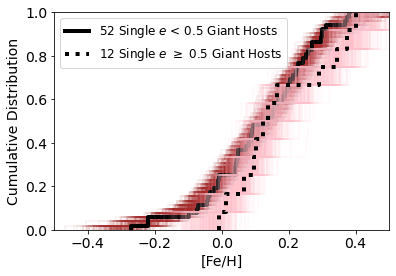

In [83]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(snotsghosts.fe_c, snotsghosts.fe_err_c)
    circhist, circ_edges = np.histogram(metals, normed=True, bins=5*len(snotsghosts))
    circchist = np.cumsum(circhist)/np.sum(circhist)
    x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), 
            color='brown', lw=2, alpha=0.05, label='_nolegend_')    

circhist, circ_edges = np.histogram(snotsghosts.fe_c, normed=True, bins=5*len(snotsghosts))
circchist = np.cumsum(circhist)/np.sum(circhist)
x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single $e$ < 0.5 Giant Hosts'.format(len(snotsghosts)))


for i in np.arange(500):
    metals = np.random.normal(stailghosts.fe_c, stailghosts.fe_err_c)
    ecchist, ecc_edges = np.histogram(metals, normed=True, bins=5*len(stailghosts))
    eccchist = np.cumsum(ecchist)/np.sum(ecchist)
    x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), 
            color='pink', lw=2, alpha=0.05, label='_nolegend_')    
    
ecchist, ecc_edges = np.histogram(stailghosts.fe_c, normed=True, bins=5*len(stailghosts))
eccchist = np.cumsum(ecchist)/np.sum(ecchist)
x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label=r'{} Single $e$ $\geq$ 0.5 Giant Hosts'.format(len(stailghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_tail_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_tail_cumulative.png', bbox_inches='tight', dpi=1000)

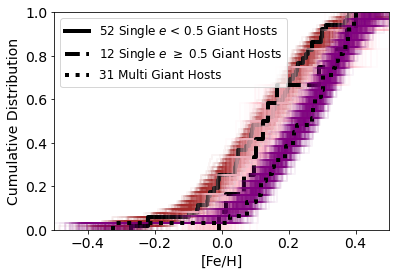

In [86]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
#'''
for i in np.arange(500):
    metals = np.random.normal(snotsghosts.fe_c, snotsghosts.fe_err_c)
    circhist, circ_edges = np.histogram(metals, normed=True, bins=5*len(snotsghosts))
    circchist = np.cumsum(circhist)/np.sum(circhist)
    x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), 
            color='brown', lw=2, alpha=0.05, label='_nolegend_')    

circhist, circ_edges = np.histogram(snotsghosts.fe_c, normed=True, bins=5*len(snotsghosts))
circchist = np.cumsum(circhist)/np.sum(circhist)
x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single $e$ < 0.5 Giant Hosts'.format(len(snotsghosts)))
#'''

for i in np.arange(500):
    metals = np.random.normal(stailghosts.fe_c, stailghosts.fe_err_c)
    ecchist, ecc_edges = np.histogram(metals, normed=True, bins=5*len(stailghosts))
    eccchist = np.cumsum(ecchist)/np.sum(ecchist)
    x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), 
            color='pink', lw=2, alpha=0.05, label='_nolegend_')    
    
ecchist, ecc_edges = np.histogram(stailghosts.fe_c, normed=True, bins=5*len(stailghosts))
eccchist = np.cumsum(ecchist)/np.sum(ecchist)
x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls='--', label=r'{} Single $e$ $\geq$ 0.5 Giant Hosts'.format(len(stailghosts)))


for i in np.arange(500):
    metals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    ecchist, ecc_edges = np.histogram(metals, normed=True, bins=5*len(stailghosts))
    eccchist = np.cumsum(ecchist)/np.sum(ecchist)
    x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
ecchist, ecc_edges = np.histogram(mghosts.fe_c, normed=True, bins=5*len(mghosts))
eccchist = np.cumsum(ecchist)/np.sum(ecchist)
x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label=r'{} Multi Giant Hosts'.format(len(mghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_tail_multi_cumulative.pdf', bbox_inches='tight')

In [40]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(stailghosts.fe_c, stailghosts.fe_err_c)
    multimetals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [30]:
print('Singles: ', np.mean(sghosts.fe_c), '+/-', np.std(sghosts.fe_c)/np.sqrt(len(sghosts.fe_c) - 1)) 
print('Single tail: ', np.mean(stailghosts.fe_c), '+/-', np.std(stailghosts.fe_c)/np.sqrt(len(stailghosts.fe_c) - 1)) 
print('Multis: ', np.mean(mghosts.fe_c), '+/-', np.std(mghosts.fe_c)/np.sqrt(len(mghosts.fe_c) - 1)) 

Singles:  0.12890935117626734 +/- 0.018998930162425817
Single tail:  0.17880821237861919 +/- 0.04102884848427065
Multis:  0.22766434685376935 +/- 0.026793720520699085


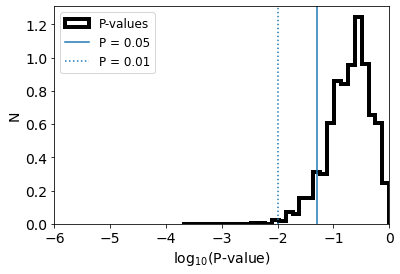

In [41]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_tail_multi_metals.pdf', bbox_inches='tight')

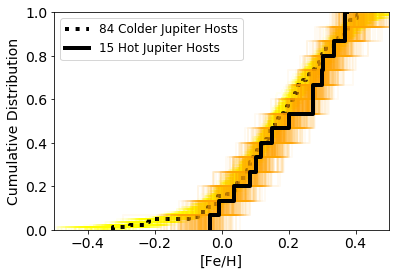

In [96]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(cghosts.fe_c, cghosts.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(cghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='yellow', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(cghosts.fe_c, normed=True, bins=5*len(cghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Colder Jupiter Hosts'.format(len(cghosts)))

for i in np.arange(500):
    metals = np.random.normal(hghosts.fe_c, hghosts.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(hghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='orange', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(hghosts.fe_c, normed=True, bins=5*len(hghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Hot Jupiter Hosts'.format(len(hghosts)))

ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/hot_cold_giant_fe_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/hot_cold_giant_fe_cumulative.png', bbox_inches='tight', dpi=1000)

## Merge single giant planet properties with specmatch table.

In [17]:
merge_columns = list(planets.columns)
merge_columns.append('fe_c')
m_good_spec = pd.DataFrame(columns=merge_columns)

planets['name'] = planets['hostname']
single_spec = pd.merge(planets.query('hostname in @singlenames'), sghosts, on=['name'])
multi_spec  = pd.merge(planets.query('hostname in @multinames'), mghosts, on=['name'])
none_spec   = pd.merge(planets.query('hostname not in @giantnames'), nghosts, on=['name'])

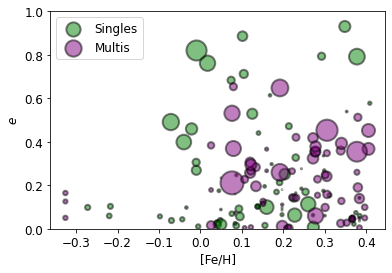

In [53]:
fig, ax = plt.subplots()

ax.scatter(single_spec.fe_c, single_spec.e_med, 
           s=list(30*single_spec.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

ax.scatter(multi_spec.fe_c, multi_spec.e_med, 
           s=list(30*multi_spec.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

ax.set_ylim([0, 1])
ax.legend(fontsize=12)

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$e$')

fig.savefig('plots/eccentricity_metallicity_comparison.pdf', bbox_inches='tight')

In [60]:
multi_spec.query('axis < 0.06')

,Unnamed: 0_x,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,logg_c,logg_err_c,radius_c,radius_err_c,mass_c,mass_err_c,index_y,star,mv,bvcolor
24,107,187123,K,1.0,0.500667,0.500908,0.485032,0.516744,0.041856,0.041856,...,4.319755,0.031995,1.154992,0.027183,1.020234,0.047963,253,187123,4.457612,0.61
46,241,75732,K,5.0,0.029567,0.029471,0.028115,0.030834,0.015826,0.015826,...,4.458131,0.031660,0.964411,0.020816,0.974708,0.045056,539,75732,5.460014,0.87
54,279,9826,K,1.0,0.674950,0.675053,0.659440,0.690768,0.059136,0.059137,...,4.125176,0.024844,1.622479,0.038881,1.294197,0.041225,596,9826,3.453482,0.54


### Split singles & multis along distance axis. Visualize first, then split at arbitrary point, then move on from there.

In [18]:
single_spec.columns

single_spec['mass_perr'] = 0.5*(single_spec['mass_plus'] - single_spec['mass_minus'])
multi_spec['mass_perr'] = 0.5*(multi_spec['mass_plus'] - multi_spec['mass_minus'])

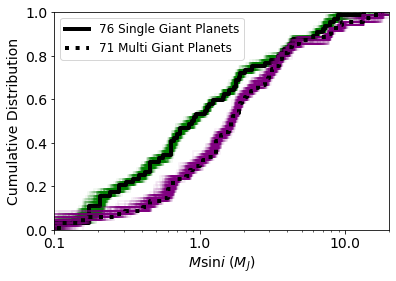

In [26]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

for i in np.arange(500):
    # Draw masses
    masses = np.random.normal(single_spec.query('mass >= 0.1').mass, single_spec.query('mass >= 0.1').mass_perr)
    solohist, solo_edges = np.histogram(masses, normed=True, bins=5*len(single_spec))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='green',
            lw=2, alpha=0.05, label='_nolegend_')

solohist, solo_edges = np.histogram(single_spec.query('mass >= 0.1').mass, normed=True, bins=5*len(single_spec))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black',
        lw=4, label='{} Single Giant Planets'.format(len(single_spec)))

for i in np.arange(500):
    # Draw masses
    masses = np.random.normal(multi_spec.query('mass >= 0.1').mass, multi_spec.query('mass >= 0.1').mass_perr)
    pairhist, pair_edges = np.histogram(masses, normed=True, bins=5*len(multi_spec))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='purple',
            lw=2, alpha=0.05, label='_nolegend_')

pairhist, pair_edges = np.histogram(multi_spec.query('mass >= 0.1').mass, normed=True, bins=5*len(multi_spec))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black',
        lw=4, ls=':', label='{} Multi Giant Planets'.format(len(multi_spec)))

ax.set_xlabel(r'$M$sin$i$ $(M_J)$')
ax.set_ylabel('Cumulative Distribution')
ax.set_ylim([0, 1])
ax.set_xlim([0.1, 20])
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_mass_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_multi_mass_cumulative.png', bbox_inches='tight', dpi=1000)

In [22]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solomasses = np.random.normal(single_spec.query('mass >= 0.1').mass, single_spec.query('mass >= 0.1').mass_perr)
    multimasses = np.random.normal(multi_spec.query('mass >= 0.1').mass, multi_spec.query('mass >= 0.1').mass_perr)
    kolmogorov = scipy.stats.ks_2samp(solomasses, multimasses)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

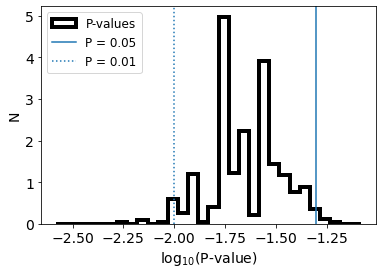

In [24]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_msinis.pdf', bbox_inches='tight')

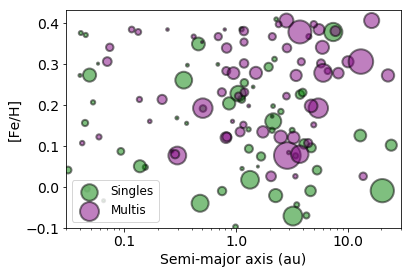

In [94]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(single_spec.query('mass >= 0.1').axis_med, single_spec.query('mass >= 0.1').fe_c, 
           s=list(40*single_spec.query('mass >= 0.1').mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

ax.scatter(multi_spec.query('mass >= 0.1').axis_med, multi_spec.query('mass >= 0.1').fe_c, 
           s=list(40*multi_spec.query('mass >= 0.1').mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

ax.legend(fontsize=12)

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.03, 30])
ax.set_ylim([-0.1, 0.43])
fig.savefig('plots/axis_metallicity_comparison.pdf', bbox_inches='tight')

In [21]:
single_spec_close = single_spec.query('axis < 1')
multi_spec_close  = multi_spec.query('axis < 1')
single_spec_far   = single_spec.query('axis >= 1')
multi_spec_far    = multi_spec.query('axis >= 1')

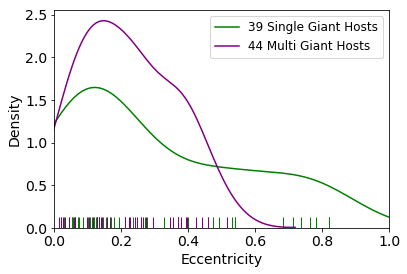

In [51]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

sns.distplot(single_spec_far.e, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Giant Hosts'.format(len(single_spec_far)))
sns.distplot(multi_spec_far.e, rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Giant Hosts'.format(len(multi_spec_far)))

ax.set_xlim([0, 1])
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Density')
ax.legend(loc=1, fontsize=12)
fig.savefig('plots/single_multi_giant_ecc_histogram.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_ecc_histogram.png', bbox_inches='tight', dpi=1000)

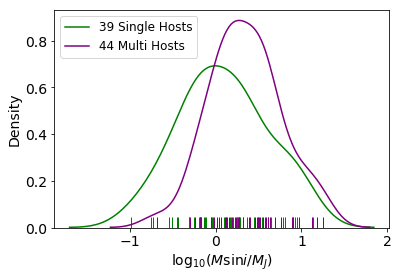

In [59]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

sns.distplot(np.log10(single_spec_far.mass), rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Hosts'.format(len(single_spec_far)))
sns.distplot(np.log10(multi_spec_far.mass), rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Hosts'.format(len(multi_spec_far)))

#ax.set_xlim([0, 1])
ax.set_xlabel(r'log$_{10}(M$sin$i/M_J$)')
ax.set_ylabel('Density')
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/single_multi_giant_msini_histogram.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_ecc_histogram.png', bbox_inches='tight', dpi=1000)

In [125]:
print(len(single_spec_close), len(multi_spec_close), len(single_spec_far), len(multi_spec_far))

37 26 39 44


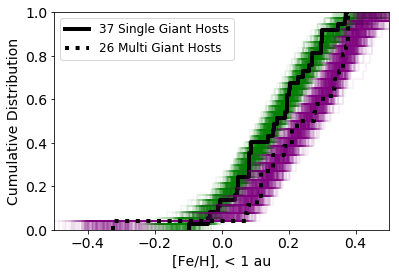

In [35]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(single_spec_close.fe_c, single_spec_close.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(single_spec_close))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(single_spec_close.fe_c, normed=True, bins=5*len(single_spec_close))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(single_spec_close)))


for i in np.arange(500):
    metals = np.random.normal(multi_spec_close.fe_c, multi_spec_close.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(multi_spec_close))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(multi_spec_close.fe_c, normed=True, bins=5*len(multi_spec_close))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(multi_spec_close)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H], < 1 au')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_close_fe_cumulative.pdf', bbox_inches='tight')

In [134]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(single_spec_close.fe_c, single_spec_close.fe_err_c)
    multimetals = np.random.normal(multi_spec_close.fe_c, multi_spec_close.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

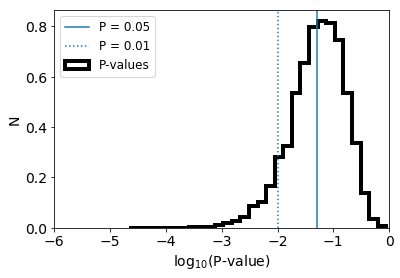

In [137]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_close_metals.pdf', bbox_inches='tight')

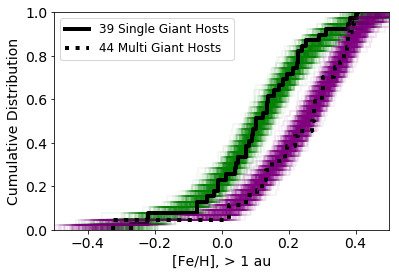

In [37]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(single_spec_far.fe_c, single_spec_far.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(single_spec_far))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(single_spec_far.fe_c, normed=True, bins=5*len(single_spec_far))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(single_spec_far)))


for i in np.arange(500):
    metals = np.random.normal(multi_spec_far.fe_c, multi_spec_far.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(multi_spec_far))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(multi_spec_far.fe_c, normed=True, bins=5*len(multi_spec_far))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(multi_spec_far)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H], > 1 au')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_far_fe_cumulative.pdf', bbox_inches='tight')

In [138]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(single_spec_far.fe_c, single_spec_far.fe_err_c)
    multimetals = np.random.normal(multi_spec_far.fe_c, multi_spec_far.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

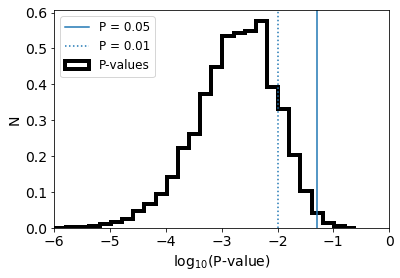

In [139]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_far_metals.pdf', bbox_inches='tight')

In [22]:
# 114762 is already listed as a binary, but drop it from the combined list. Also drop bad binary residual fits.
bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215'] # 167215 has a good eccentric binary, and a circular wobble we can't fit out.
objects_good['name'] = objects_good['hostname']
total_spec = pd.merge(objects_good, specmatch, on=['name']).query('fe_c > -0.6 and name not in @bad_names')

In [49]:
with open('names_giant_single.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in singlenames:
        if name not in bad_names:
            writer.writerow([val])

with open('names_giant_multi.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in multinames:
        if name not in bad_names:
            writer.writerow([val])

In [15]:
median_fe_giant = np.median(ghosts.fe_c)
poornames = np.unique(ghosts.query('fe_c <= @median_fe_giant').name)
richnames = np.unique(ghosts.query('fe_c > @median_fe_giant').name)

In [19]:
with open('names_giant_poor.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in poornames:
        writer.writerow([val])

with open('names_giant_rich.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in richnames:
        writer.writerow([val])

## Compare completeness of single-found giant and multi-found giant systems.

In [17]:
recoveries_gpoor = pd.read_csv('../recovery_files/recoveries_giant_poor_earth.csv')
completey_gpoor  = Completeness(recoveries_gpoor)
completey_gpoor.completeness_grid([0.01, 40], [2, 9000])

recoveries_grich = pd.read_csv('../recovery_files/recoveries_giant_rich_earth.csv')
completey_grich  = Completeness(recoveries_grich)
completey_grich.completeness_grid([0.01, 40], [2, 9000])

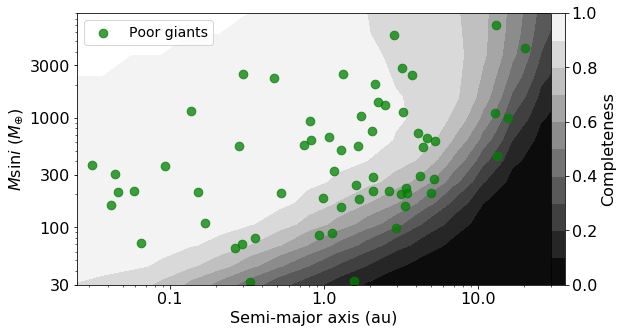

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.set_yticks((30, 100, 300, 1000, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_gpoor.grid[0], completey_gpoor.grid[1],
                 completey_gpoor.grid[2], 10, cmap=plt.cm.gray)

ax.scatter(total_spec.query('fe_c <= @median_fe_giant').axis, 
           317.8*total_spec.query('fe_c <= @median_fe_giant').mass, 
           c='g', s=75, alpha=0.75, label='Poor giants')

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([30, 9000])

ymin, ymax = ax.get_ylim()

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/contours_giant_poor.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/contours_giant_poor.pdf', bbox_inches='tight')

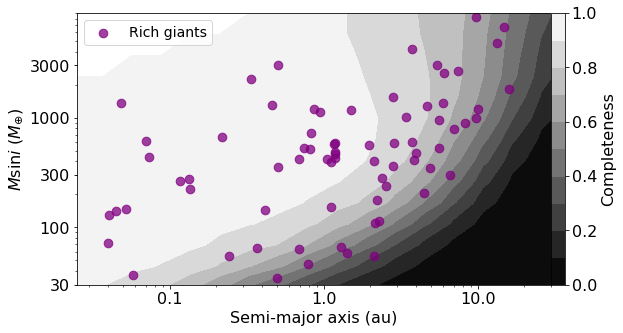

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.set_yticks((30, 100, 300, 1000, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_grich.grid[0], completey_grich.grid[1],
                 completey_grich.grid[2], 10, cmap=plt.cm.gray)

ax.scatter(total_spec.query('fe_c > @median_fe_giant').axis, 
           317.8*total_spec.query('fe_c > @median_fe_giant').mass, 
           c='purple', s=75, alpha=0.75, label='Rich giants')

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([30, 9000])

ymin, ymax = ax.get_ylim()
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/contours_giant_rich.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/contours_giant_rich.pdf', bbox_inches='tight')

In [23]:
objects_list = objects_good.query('hostname not in @bad_names and mass > 0.1')

In [24]:
objects_list = objects_list.sort_values('mass', ascending=False)

In [33]:
objects_list.to_csv('legacy_sorted_mass.csv')

## Look at total planetary mass, rather than multiplicity.

In [50]:
pnames = np.unique(planets.query('mass >= 0.09').hostname) #.query('mass >= 0.1') #objects_list
metals = [np.array(specmatch.query('name == @pname').fe_c)[0] for pname in pnames]
masses = [np.array(specmatch.query('name == @pname').mass_c)[0] for pname in pnames]
tmass  = [np.sum(planets.query('hostname == @pname').mass) for pname in pnames]

In [19]:
bad_names

['114762', '143761', '28185', '42581', '8375', '72659', '167215']

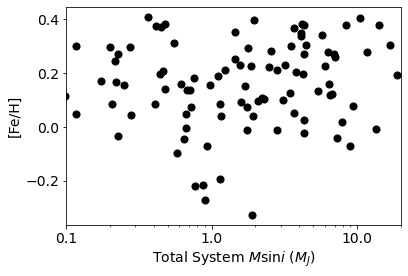

In [51]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(tmass, metals, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.1, 20])

fig.savefig('plots/metals_vs_totmsini.pdf', bbox_inches='tight')

## Compute Pearson correlation. Basic, then many draws with uncertainty & sini.

In [27]:
def R(x, y):
    return np.sum((x - np.mean(x))*(y - np.mean(y)))/\
           np.sqrt(np.sum((x - np.mean(x))**2)*np.sum((y - np.mean(y))**2))

def devvy(M1, M2):   
    return np.std(np.log(M1) - np.log(M2))

In [17]:
R(tmass, metals)

0.11683651088183374

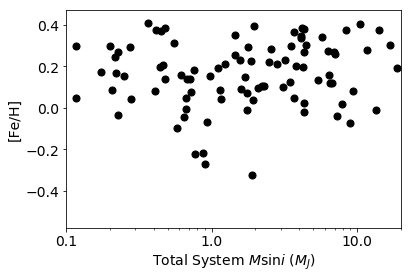

In [42]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(tmass, metals, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.1, 20])

fig.savefig('plots/metals_vs_totmsini_os.pdf', bbox_inches='tight')

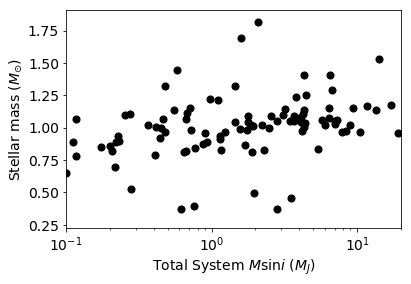

In [99]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.scatter(tmass, masses, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel(r'Stellar mass ($M_{\odot}$)')
ax.set_xlim([0.1, 20])
#ax.set_ylim([0.5, 1.6])
ax.set_xscale('log')

fig.savefig('plots/smass_vs_totmsini.pdf', bbox_inches='tight')

In [18]:
R(tmass, masses)

0.22534941143999918

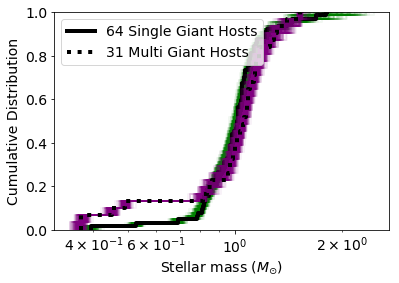

In [70]:
fig, ax = plt.subplots()

smghosts = mghosts.query('mass_c > 0.7')
ssghosts = sghosts.query('mass_c > 0.7')

for i in np.arange(500):
    metals = np.random.normal(sghosts.mass_c, sghosts.mass_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(sghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(sghosts.mass_c, normed=True, bins=5*len(sghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(sghosts)))


for i in np.arange(500):
    metals = np.random.normal(mghosts.mass_c, mghosts.mass_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(mghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(mghosts.mass_c, normed=True, bins=5*len(mghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(mghosts)))


#ax.set_xlim([-0.5, 0.5])
ax.set_xscale('log')
ax.set_ylim([0., 1.0])
ax.set_xlabel(r'Stellar mass ($M_{\odot}$)')
ax.set_ylabel('Cumulative Distribution')
ax.legend(loc=2, fontsize=12)

fig.savefig('plots/single_multi_giant_hostmass_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_multi_giant_hostmass_cumulative.png', bbox_inches='tight', dpi=1000)

In [74]:
# Remove low-mass outliers for one version of the comparison, keep for another.
kolmogorovs = []
probs = []
skolmogorovs = []
sprobs = []
for i in np.arange(10**5):
    ssolomasses = np.random.normal(ssghosts.mass_c, ssghosts.mass_err_c)
    smultimasses = np.random.normal(smghosts.mass_c, smghosts.mass_err_c)
    skolmogorov = scipy.stats.ks_2samp(ssolomasses, smultimasses)
    
    solomasses = np.random.normal(sghosts.mass_c, sghosts.mass_err_c)
    multimasses = np.random.normal(mghosts.mass_c, mghosts.mass_err_c)
    kolmogorov = scipy.stats.ks_2samp(solomasses, multimasses)
    
    skolmogorovs.append(skolmogorov[0])
    sprobs.append(skolmogorov[1])
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

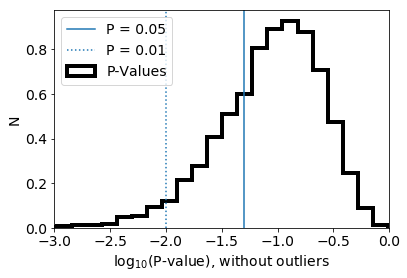

In [85]:
fig, ax = plt.subplots()
ax.hist(np.log10(sprobs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value), without outliers')
ax.set_ylabel('N')
ax.set_xlim([-3, 0])
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_smass.pdf', bbox_inches='tight')

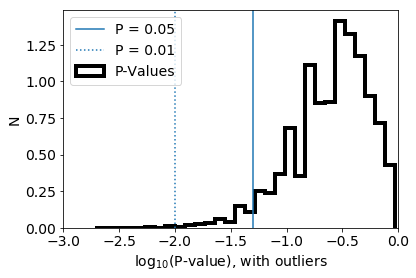

In [86]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value), with outliers')
ax.set_ylabel('N')
ax.set_xlim([-3, 0])
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_mass.pdf', bbox_inches='tight')

In [30]:
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
pairs['mass_perr'] = 0.5*(pairs['mass_plus'] - pairs['mass_minus'])
x = []
y = []
ex = []
ey = []
z = []
for hostname in pairs.hostname:
    x.append(np.array(pairs.query('hostname==@hostname').mass)[0])
    y.append(np.array(pairs.query('hostname==@hostname').mass)[1])
    ex.append(np.array(pairs.query('hostname==@hostname').e)[0])
    ey.append(np.array(pairs.query('hostname==@hostname').e)[1])
    z.append(np.array(specmatch.query('name==@hostname').fe_c)[0])

R(np.log(x), np.log(y))

0.4478550010856209

In [19]:
pairs.to_csv('legacy_giant_pairs.csv')

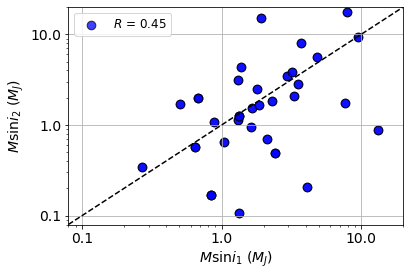

In [29]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
    
ax.scatter(x, y, c='blue', edgecolors='black', alpha=0.75, 
           s=75, linewidth=1, label=r'$R$ = 0.45')

ax.plot(np.linspace(0.08, 20, 20), \
        np.linspace(0.08, 20, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0.08, 20])
ax.set_ylim([0.08, 20])
ax.set_xlabel(r'$M$sin$i_1$ ($M_J$)')
ax.set_ylabel(r'$M$sin$i_2$ ($M_J$)')

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_yscale('log')
ax.set_yticks((0.1, 1, 10))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(loc=2, fontsize=12)

fig.savefig('plots/logmsini_correlation.pdf', bbox_inches='tight')

## Bootstrap for uncertainty in R.

In [40]:
arrrrrrs = []
for i in np.arange(10**3):
    x = []
    y = []
    for hostname in pairs.hostname:
        x.append(np.abs(np.random.normal(np.array(pairs.query('hostname==@hostname').mass)[0], 
                                         np.array(pairs.query('hostname==@hostname').mass_perr)[0])))
        y.append(np.abs(np.random.normal(np.array(pairs.query('hostname==@hostname').mass)[1], 
                                         np.array(pairs.query('hostname==@hostname').mass_perr)[1])))
    arrrrrrs.append(R(np.log(x), np.log(y)))

0.010455672297496058

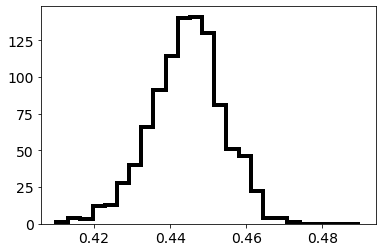

In [43]:
fig, ax = plt.subplots()
ax.hist(arrrrrrs, histtype='step', bins=25, range=(0.41, 0.49), lw=4, color='black')
np.std(arrrrrrs)

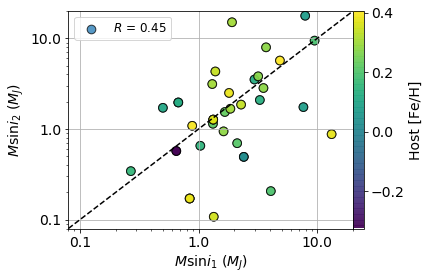

In [33]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
    
im = ax.scatter(x, y, c=z, edgecolors='black', alpha=0.75, 
                s=75, linewidth=1, label=r'$R$ = 0.45')
plt.colorbar(mappable=im, pad=0, label='Host [Fe/H]')

ax.plot(np.linspace(0.08, 20, 20), \
        np.linspace(0.08, 20, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0.08, 20])
ax.set_ylim([0.08, 20])
ax.set_xlabel(r'$M$sin$i_1$ ($M_J$)')
ax.set_ylabel(r'$M$sin$i_2$ ($M_J$)')

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_yscale('log')
ax.set_yticks((0.1, 1, 10))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(loc=2, fontsize=12)

fig.savefig('plots/logmsini_correlation_metal.pdf', bbox_inches='tight')

In [18]:
pairs = planets.query('mass >= 0.1 and hostname in @multinames')

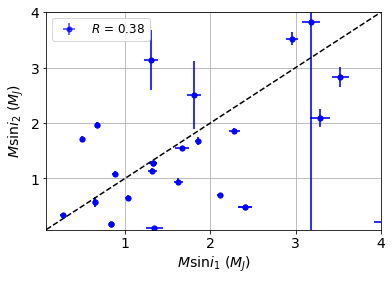

In [55]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
x = []
y = []
rx = []
ry = []
for hostname in pairs.hostname:
    x.append(np.array(pairs.query('hostname==@hostname').mass)[0])
    y.append(np.array(pairs.query('hostname==@hostname').mass)[1])
    rx.append(0.5*(np.array(pairs.query('hostname==@hostname').mass_plus)[0] - np.array(pairs.query('hostname==@hostname').mass_minus)[0]))
    ry.append(0.5*(np.array(pairs.query('hostname==@hostname').mass_plus)[1] - np.array(pairs.query('hostname==@hostname').mass_minus)[1]))
    
ax.errorbar(x, y, xerr=rx, yerr=ry, c='blue', alpha=0.75, 
           label=r'$R$ = 0.38', fmt='o')

ax.plot(np.linspace(0.08, 20, 20), \
        np.linspace(0.08, 20, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0.08, 4])
ax.set_ylim([0.08, 4])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$M$sin$i_1$ ($M_J$)')
ax.set_ylabel(r'$M$sin$i_2$ ($M_J$)')

#ax.set_xscale('log')
#ax.set_xticks((0.1, 1, 10))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

#ax.set_yscale('log')
#ax.set_yticks((0.1, 1, 10))
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(loc=2, fontsize=12)

fig.savefig('plots/msini_correlation_linear.pdf', bbox_inches='tight')

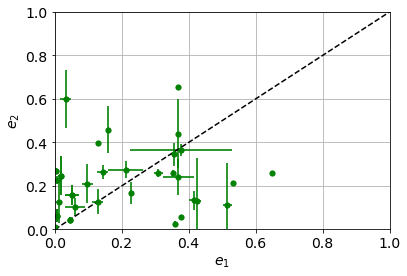

In [54]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
ex = []
ey = []
rx = []
ry = []
for hostname in pairs.hostname:
    ex.append(np.array(pairs.query('hostname==@hostname').e)[0])
    ey.append(np.array(pairs.query('hostname==@hostname').e)[1])
    rx.append(0.5*(np.array(pairs.query('hostname==@hostname').e_plus)[0] - np.array(pairs.query('hostname==@hostname').e_minus)[0]))
    ry.append(0.5*(np.array(pairs.query('hostname==@hostname').e_plus)[1] - np.array(pairs.query('hostname==@hostname').e_minus)[1]))
    
ax.errorbar(ex, ey, xerr=rx, yerr=ry, c='green', alpha=0.75, fmt='o')

ax.plot(np.linspace(0, 1, 20), \
        np.linspace(0, 1, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$e_1$')
ax.set_ylabel(r'$e_2$')

#ax.legend(loc=2, fontsize=12)

fig.savefig('plots/msini_correlation_linear.pdf', bbox_inches='tight')

In [ ]:
def amd(mplanet, mstar, e)

## Randomly sample & measure correlation. Presumably random, let's be sure. With replacement. Lumping triples-and-on in with the pairs.

In [19]:
correlations = []
for i in range(10**5):
    M1 = np.random.choice(pairs.mass, size=int(len(pairs)/2), replace=False)
    M2 = np.random.choice(list(set(pairs.mass) - set(M1)), size=int(len(pairs)/2), replace=False)
    correlations.append(R(np.log(M1), np.log(M2)))

## Now get rid of the triples-and-on, only use the first two giants in each system.

In [29]:
real_pairs = pairs.query('pl_index <= 2') # Imperfect, could cut out small planets, but happens to work.
#real_pairs.to_csv('legacy_giant_pairs.csv')

In [30]:
two_correlations = []
for i in range(10**5):
    M1 = np.random.choice(real_pairs.mass, size=int(len(real_pairs)/2), replace=False)
    M2 = np.random.choice(list(set(real_pairs.mass) - set(M1)), size=int(len(real_pairs)/2), replace=False)
    two_correlations.append(R(np.log(M1), np.log(M2)))

In [32]:
np.percentile(two_correlations, 99.7)

0.4845621096283815

In [33]:
#stats.percentileofscore(correlations, 0.45)
stats.percentileofscore(two_correlations, 0.447855)

99.434

## Now take completeness into account. Sample with replacement.

In [19]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
axislims = [0.1, 20]
masslims = [30, 6000]
completey_all.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])

In [23]:
complete_correlations = []
complete_devvys = []
a_array = np.array(real_pairs.axis)
m_array = np.array(real_pairs.mass)
indices = np.arange(len(real_pairs))
completeyray = [completey_all.interpolate(a_array[i], m_array[i]) for i in indices]

n = int(len(real_pairs)/2)
for i in range(10**3):
    M1 = []
    M2 = []
    j = 0
    while j < n:
        #one_pair = real_pairs.sample(n=2,replace=False).reset_index(drop=True)
        one_pair = np.random.choice(indices, size=2, replace=False)
        a1, m1 = a_array[one_pair[0]], m_array[one_pair[0]]
        a2, m2 = a_array[one_pair[1]], m_array[one_pair[1]]
        completey1, completey2 = completeyray[one_pair[1]], completeyray[one_pair[1]]
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2:
            M1.append(m1)
            M2.append(m2)
            j += 1
    complete_correlations.append(R(np.log(M1), np.log(M2)))
    complete_devvys.append(devvy(M1, M2))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


KeyboardInterrupt: 

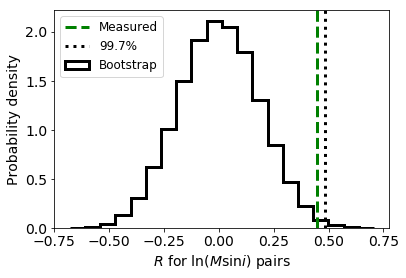

In [37]:
# OLD, SAMPLING WITHOUT REPLACEMENT AND WITHOUT COMPLETENESS
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(two_correlations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(0.447855, ls='--', color='green', lw=3, label='Measured')
ax.axvline(np.percentile(two_correlations, 99.7), ls=':', 
           lw=3, color='black', label='99.7%')
ax.set_xlabel(r'$R$ for ln($M$sin$i$) pairs')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/bootstrapped_two_correlation.pdf', bbox_inches='tight')

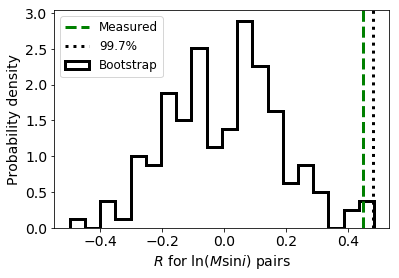

In [25]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(complete_correlations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(0.447855, ls='--', color='green', lw=3, label='Measured')
ax.axvline(np.percentile(complete_correlations, 99.7), ls=':', 
           lw=3, color='black', label='99.7%')
ax.set_xlabel(r'$R$ for ln($M$sin$i$) pairs')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/bootstrapped_correlation_completeness.pdf', bbox_inches='tight')

ValueError: color kwarg must have one color per data set. 64 data sets and 1 colors were provided

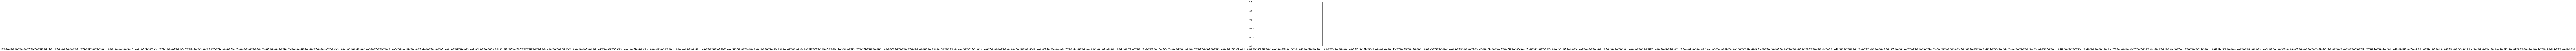

In [23]:
cadence_corrs = pd.read_csv('correlations_deviations_completeness.csv')

complete_correlations = np.array(cadence_corrs.correlation)
complete_deviations = np.array(cadence_corrs.deviation)

fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(complete_correlations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(0.447855, ls='--', color='green', lw=3, label='Measured')
ax.axvline(np.percentile(complete_correlations, 99.7), ls=':', 
           lw=3, color='black', label='99.7%')
ax.set_xlabel(r'$R$ for ln($M$sin$i$) pairs')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/bootstrapped_correlation_completeness.pdf', bbox_inches='tight')

In [27]:
complete_correlations[0]

'[0.02012338439093739, 0.007296798164857436, -0.09510053993578978, -0.012841462604046614, -0.030482162153931777, -0.0870967136346147, -0.04244601279889494, -0.0878543392456139, 0.007907125901178973, -0.16619206258368396, -0.11164351611806811, -0.20635811210203128, 0.005133752487096426, -0.22763446155105613, 0.04297972034309318, -0.043739522401103216, 0.011726203676679906, 0.06717043598126086, 0.05564522898235866, 0.05847816748062704, 0.044493194009305896, 0.06795105957754728, -0.13148725206335485, 0.14922114987861496, -0.02769101311356481, -0.06167960960464324, -0.05119152795295167, -0.19035681581262429, 0.027156715556977296, 0.1834026381029124, -0.05892188056659967, -0.08010094982444127, 0.024642026705529414, -0.006401392159532116, -0.0983048865989995, 0.0252875160218686, -0.05337770846634013, -0.01738854400476846, -0.018709520202922016, -0.03753436868061428, -0.0010492678721071606, -0.08765176318909627, 0.05412146695985865, -0.06579857491240858, -0.14288403674791084, -0.1552355868759

## Bootstrap absolute deviation.

In [65]:
logmassratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logmassratios.append(np.log10(np.array(pair.mass)[0]) - \
                             np.log10(np.array(pair.mass)[1]))

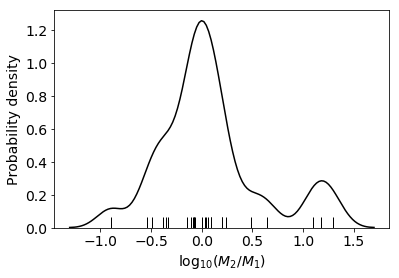

In [72]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
#ax.set_xlim([np.amin(logmassratios) - 0.1, np.amax(logmassratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($M_2/M_1$)')
ax.set_ylabel(r'Probability density')
sns.distplot(logmassratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/observed_mass_ratios.pdf', bbox_inches='tight')

In [38]:
def devvy(M1, M2):   
    return np.std(np.log(M1) - np.log(M2))

In [40]:
deviations = []
for i in range(50000):
    M1 = np.random.choice(real_pairs.mass, size=int(len(real_pairs)/2), replace=False)
    M2 = np.random.choice(list(set(real_pairs.mass) - set(M1)), size=int(len(real_pairs)/2), replace=False)
    deviations.append(np.std(np.log(M1) - np.log(M2)))
    #deviations.append(np.percentile(np.abs(np.log10(M1) - np.log10(M2)), 84.1))

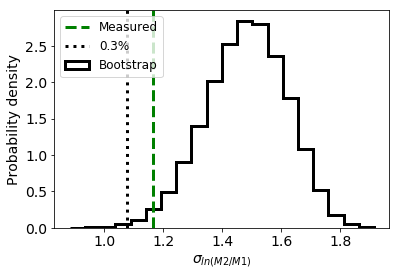

In [45]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(deviations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(np.std(logmassratios), ls='--', lw=3, color='green', label='Measured')
ax.axvline(np.percentile(deviations, 0.3), ls=':', 
           lw=3, color='black', label='0.3%')
ax.set_xlabel(r'$\sigma_{ln(M2/M1)}$')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12, loc=2)

#fig.savefig('plots/bootstrapped_deviation.pdf', bbox_inches='tight')

In [67]:
stats.percentileofscore(deviations, np.std(logmassratios))

1.428

## Could there be observational biases that produce an observed correlation? Draw from inferred mass/axis distribution, see if we observe a fake correlation when paired with completeness contours.

## Make it easier, just draw from uniform ln(M)/ln(a) distribution.

In [37]:
nmultisets = len(np.unique(planets_multi.hostname))

In [28]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
axislims = [0.1, 20]
masslims = [30, 6000]
completey_all.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])

In [22]:
# Pretend distributions are log-uniform. Obviously not true, figure out if it matters.
def draw_pair(completey, axislims=[0.1, 20], masslims=[30, 6000], npairs=100):
    completey.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])
    lnalims = np.log(axislims)
    lnmlims = np.log(masslims)
    pairys = []
    while len(pairys) < npairs:
        lna1, lna2 = np.random.uniform(low=lnalims[0], high=lnalims[1], size=2)  
        lnm1, lnm2 = np.random.uniform(low=lnmlims[0], high=lnmlims[1], size=2)  
        completey1 = completey.interpolate(np.exp(lna1), np.exp(lnm1))
        completey2 = completey.interpolate(np.exp(lna2), np.exp(lnm2))
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2:
            pairys.append([[lna1, lna2], [lnm1, lnm2]])
    return np.array(pairys)

In [53]:
pairytest = draw_pair(completey_all)

In [57]:
lnmassys = pairytest[:, 1]#np.exp()
R(lnmassys[:, 0], lnmassys[:, 1])

-0.12584139082121984

In [37]:
arrs = []
devs = []
for i in range(50):
    perry = draw_pair(completey_all)
    arrs.append(R(perry[:, 1][:, 0], perry[:, 1][:, 1]))
    devs.append(devvy(perry[:, 1][:, 0], perry[:, 1][:, 1]))

NameError: name 'draw_pair' is not defined

In [69]:
print('R = ', np.median(arrs), '+/-', np.std(arrs))
print('D = ', np.median(devs), '+/-', np.std(devs))

R =  -0.007621084470677373 +/- 0.10238444395116232
D =  0.13720468208565595 +/- 0.01025272884094157


### Recode with split at ice line. 2/11th 0.1--1 au, 9/11ths 1--20 au. 1/4th 0.1--1 au, 4/5th 1--10 au.

In [27]:
# Hard-code the split for now, good enough. Refine it after measuring the exact split.
def draw_pair_split(completey, axislims=[0.1, 20], masslims=[30, 6000], npairs=100):
    lnalims = np.log(axislims)
    lnmlims = np.log(masslims)
    pairys = []
    while len(pairys) < npairs:
        # Pick a random number, decide whether to sample from within or beyond ice line.
        icey1, icey2 = np.random.uniform(low=0, high=1, size=2)
        if icey1 < 2/11:
            lna1 = np.random.uniform(low=lnalims[0], high=0)  
        else:            
            lna1 = np.random.uniform(low=0, high=lnalims[1])  
        if icey2 < 2/11:
            lna2 = np.random.uniform(low=lnalims[0], high=0)  
        else:            
            lna2 = np.random.uniform(low=0, high=lnalims[1])  
        lnm1, lnm2 = np.random.uniform(low=lnmlims[0], high=lnmlims[1], size=2)    
            
        completey1 = completey.interpolate(np.exp(lna1), np.exp(lnm1))
        completey2 = completey.interpolate(np.exp(lna2), np.exp(lnm2))
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2 and abs(lna1 - lna2 >= 0.5):
            pairys.append([[lna1, lna2], [lnm1, lnm2]])
    return np.array(pairys)

In [29]:
perry = draw_pair_split(completey_all, npairs=1000)

In [38]:
arrs = []
devs = []
for i in range(10000):
    perry = draw_pair_split(completey_all, npairs=nmultisets)
    arrs.append(R(perry[:, 1][:, 0], perry[:, 1][:, 1]))
    devs.append(devvy(np.exp(perry[:, 1][:, 0]), np.exp(perry[:, 1][:, 1])))

In [36]:
arrs

[-0.008624612049501693,
 -0.07555488043970333,
 0.015421295814477931,
 -0.27088749341830487,
 0.10987573374951992,
 -0.09326768555477677,
 0.14717335384204386,
 0.029324709562906524,
 0.03278390567025862,
 0.022171368346598008,
 -0.03280559611402699,
 -0.2639294899013671,
 0.1760596623700374,
 0.3836934820306893,
 0.13816247836727794,
 -0.01169592682452002,
 0.04352200227785529,
 0.11929009203911155,
 -0.04671251503791248,
 -0.14694901310990635,
 -0.08283535257975493,
 -0.20043407264285948,
 -0.22838474078752405,
 -0.03401023927162233,
 -0.20657715908623894,
 -0.11700444168300499,
 0.15403241916992674,
 -0.24189524183174124,
 0.13881601593176926,
 0.24247855210184063,
 0.1875733851372418,
 0.18248453959472385,
 0.10482148252230673,
 0.02295030920399941,
 0.1366869833517428,
 0.19595902889463052,
 -0.18326932542118987,
 -0.03680198847769171,
 -0.11638399950188398,
 -0.15503173899846168,
 0.07967457753131028,
 -0.13653432160048673,
 0.2712360222833987,
 -0.01816572835515872,
 -0.06730094

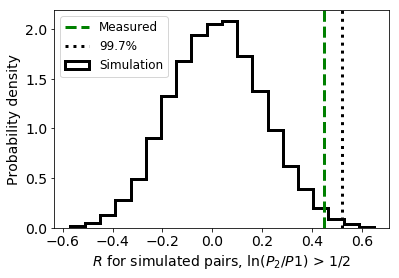

In [41]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.axvline(0.447855, ls='--', lw=3, color='green', label='Measured')
ax.axvline(np.percentile(arrs, 99.7), ls=':', lw=3,
           color='black', label='99.7%')
ax.hist(arrs, histtype='step', color='black', lw=3, 
        density=True, bins=20, label='Simulation')
ax.set_xlabel(r'$R$ for simulated pairs, ln($P_2/P1$) > 1/2')
ax.set_ylabel(r'Probability density')
ax.legend(fontsize=12, loc=2)
fig.savefig('plots/simulated_arr_split.pdf', bbox_inches='tight')

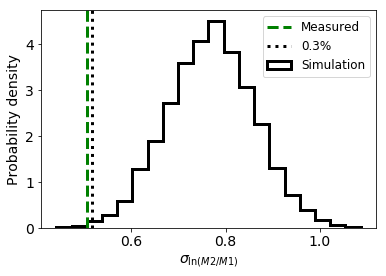

In [42]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(devs, histtype='step', color='black', lw=3,
        density=True, bins=20, label='Simulation')
ax.axvline(np.std(logmassratios), ls='--', lw=3,
           color='green', label='Measured')
ax.axvline(np.percentile(devs, 0.3), ls=':', 
           lw=3, color='black', label='0.3%')
ax.set_xlabel(r'$\sigma_{\mathrm{ln}(M2/M1)}$')# for simulated pairs, ln($P_2/P1$) > 1/2
ax.set_ylabel('Probability density')
ax.legend(fontsize=12, loc=1)

fig.savefig('plots/simulated_deviation_split.pdf', bbox_inches='tight')

In [43]:
stats.percentileofscore(arrs, 0.447855)

98.96

In [44]:
stats.percentileofscore(correlations, 0.447855)

99.605